## analyze LFP from DR recordings

In [56]:
#Import packages
import pandas as pd
import h5py
import numpy as np
import scipy as sp
import scipy.signal as sg
import scipy.stats as st
import xarray as xr
import os
import matplotlib.pyplot as plt
from matplotlib import patches
import ast
import glob
import re
import time

from DR_analysis_utils import Session, makePSTH, make_neuron_time_trials_tensor 
from DR_analysis_utils import compute_smoothed_response_rate, compute_block_modulation

%matplotlib notebook

In [ ]:
# %load_ext autoreload
# %autoreload 2

In [58]:
main_path = [
    r"\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\DRpilot_626791_20220815\processed",
    r"\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\DRpilot_626791_20220816\processed",
    r"\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\DRpilot_626791_20220817\processed",
    
    r"\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\DRpilot_636766_20230123\processed", 
    r"\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\DRpilot_636766_20230124\processed", 
    r"\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\DRpilot_636766_20230125\processed", 
    r"\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\DRpilot_636766_20230126\processed", 
    r"\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\DRpilot_644864_20230130\processed",
    r"\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\DRpilot_644864_20230131\processed", 
    r"\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\DRpilot_644864_20230201\processed", 
    r"\\allen\programs\mindscope\workgroups\np-exp\PilotEphys\Task 2 pilot\DRpilot_644864_20230202\processed",
#     r"\\allen\programs\mindscope\workgroups\np-exp\PilotEphys\Task 2 pilot\DRpilot_644866_20230207\processed", 
    #some error with this one's processing ^
    r"Y:\DRpilot_644866_20230208\processed",
    r"Y:\DRpilot_644866_20230209\processed",
    r"Y:\DRpilot_644866_20230210\processed",
    r"Y:\DRpilot_644867_20230220\processed",
    r"Y:\DRpilot_644867_20230221\processed",
    r"Y:\DRpilot_644867_20230222\processed",
    r"Y:\DRpilot_644867_20230223\processed",
    r"Y:\DRpilot_649943_20230213\processed", 
    r"Y:\DRpilot_649943_20230214\processed",
    r"Y:\DRpilot_649943_20230215\processed",
    r"Y:\DRpilot_649943_20230216\processed",
]

In [4]:
sel_session=20
session=Session(path=main_path[sel_session])
session.assign_unit_areas()


probeA areas found
probeB areas found
probeC areas found
probeD areas found
probeE areas found
probeF areas found


In [5]:
session.good_units.query('probe == "A"')['area'].unique()

array(['CP', 'N/A', 'MOp6b', 'MOp6a', 'MOs6a', 'MOs5', 'MOs2/3'],
      dtype=object)

In [6]:
#LFP timestamps

probe='A'

lfp_path=session.metadata['syncData'][probe]['dirName'].replace('AP','LFP')
lfp_samples_path=os.path.join(lfp_path,"sample_numbers.npy")

lfp_samples=np.load(lfp_samples_path)
lfp_samples=lfp_samples-np.min(lfp_samples)

lfp_timestamps = lfp_samples/(session.metadata['syncData'][probe]['LFPsampleRate']) - session.metadata['syncData'][probe]['shift']
lfp_timestamps

array([  17.60945132,   17.60985132,   17.61025131, ..., 4828.65518855,
       4828.65558855, 4828.65598855])

In [ ]:
# remapping_pattern = np.array([0, 12, 1, 13, 2, 14, 3, 15, 4, 16, 5, 17, 6, 18, 7, 19, 
#               8, 20, 9, 21, 10, 22, 11, 23, 24, 36, 25, 37, 26, 38,
#               27, 39, 28, 40, 29, 41, 30, 42, 31, 43, 32, 44, 33, 45, 34, 46, 35, 47])

# channel_order = np.concatenate([remapping_pattern + 48*i for i in range(0,8)])

In [7]:
#LFP signal

lfp_signal=np.memmap(os.path.join(lfp_path,'continuous.dat'),dtype='int16',mode='r')
lfp_signal=np.reshape(lfp_signal, (int(lfp_signal.size / 384), 384))

lfp_channel_ind=np.arange(0,384)

sample_frequency = session.metadata['syncData'][probe]['LFPsampleRate']


In [8]:
#load confirmed surface channels
surface_channels=pd.read_csv(r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\DRpilot_surface_estimates.csv")

In [ ]:
# surface_channels
# 2**13

In [42]:
#for every trial, extract & normalize LFP

nchannels=384
nfft=2**12

channels = np.arange(nchannels).astype('int')

#get surface channel for this session + probe
mouse_session=str(session.metadata['mouseID'])+'_'+str(session.metadata['ephys_session_num'])
probe_surface_channel = int(surface_channels.query('session ==  @mouse_session')['probe'+probe].values)+20

lfp_tensor=np.zeros((1250,384,len(session.trials)),dtype='int16')
power = np.zeros((int(nfft/2+1), nchannels, len(session.trials)))

pre_chunk = np.copy(lfp_signal[20*2500:50*2500,channels])
pre_chunk_median = np.median(pre_chunk,0)
pre_chunk = []

#loop through all trials
for tt, trial in session.trials.iterrows():
    startPt = int((trial['stimStartTime']-0.5)*sample_frequency)
    endPt = int(startPt + int(sample_frequency)*0.5)
    
    channel_range = [probe_surface_channel, 383]#probe_surface_channel+20]
    
    chunk = np.copy(lfp_signal[startPt:endPt,channels]) - pre_chunk_median
    
    #subtract median of agar channels
    chunk = (chunk.T - np.median(chunk[:,channel_range[0]:channel_range[1]],1).T).T
#     for ch in np.arange(nchannels):
#         chunk[:,ch] = chunk[:,ch] - pre_chunk_median #np.median(chunk[:,ch],0)

    for ch in np.arange(nchannels):
#         chunk[:,ch] = chunk[:,ch] - np.median(chunk[:,channel_range[0]:channel_range[1]],1)

        sample_frequencies, Pxx_den = sg.welch(chunk[:,ch], fs=sample_frequency, nfft=nfft)
        power[:,ch,tt] = Pxx_den
        
    lfp_tensor[:,:,tt]=chunk
    
    chunk=[]
    
    print('trial ',tt,' done')

trial  0  done
trial  1  done
trial  2  done
trial  3  done
trial  4  done
trial  5  done
trial  6  done
trial  7  done
trial  8  done
trial  9  done
trial  10  done
trial  11  done
trial  12  done
trial  13  done
trial  14  done
trial  15  done
trial  16  done
trial  17  done
trial  18  done
trial  19  done
trial  20  done
trial  21  done
trial  22  done
trial  23  done
trial  24  done
trial  25  done
trial  26  done
trial  27  done
trial  28  done
trial  29  done
trial  30  done
trial  31  done
trial  32  done
trial  33  done
trial  34  done
trial  35  done
trial  36  done
trial  37  done
trial  38  done
trial  39  done
trial  40  done
trial  41  done
trial  42  done
trial  43  done
trial  44  done
trial  45  done
trial  46  done
trial  47  done
trial  48  done
trial  49  done
trial  50  done
trial  51  done
trial  52  done
trial  53  done
trial  54  done
trial  55  done
trial  56  done
trial  57  done
trial  58  done
trial  59  done
trial  60  done
trial  61  done
trial  62  done
tr

trial  489  done
trial  490  done
trial  491  done
trial  492  done
trial  493  done
trial  494  done
trial  495  done
trial  496  done
trial  497  done
trial  498  done
trial  499  done
trial  500  done
trial  501  done
trial  502  done
trial  503  done
trial  504  done
trial  505  done
trial  506  done
trial  507  done
trial  508  done
trial  509  done
trial  510  done
trial  511  done
trial  512  done
trial  513  done
trial  514  done
trial  515  done
trial  516  done
trial  517  done
trial  518  done
trial  519  done
trial  520  done
trial  521  done
trial  522  done
trial  523  done
trial  524  done
trial  525  done
trial  526  done
trial  527  done
trial  528  done
trial  529  done
trial  530  done
trial  531  done
trial  532  done
trial  533  done
trial  534  done
trial  535  done
trial  536  done
trial  537  done
trial  538  done
trial  539  done
trial  540  done
trial  541  done
trial  542  done
trial  543  done
trial  544  done
trial  545  done
trial  546  done


In [51]:
path=r'D:\DR\LFP analysis'

# np.save(os.path.join(path,'lfp_tensor_test.npy'),lfp_tensor)
np.save(os.path.join(path,'power_tensor_test.npy'),power[:200,:,:])


In [50]:
power.shape

(2049, 384, 547)

In [12]:
endPt

2693026.0

In [ ]:
# #find power in pre-stim time for each trial

# power = np.zeros((int(nfft/2+1), nchannels, len(session.trials)))

# for tt in range(0,len(session.trials)):
    
#     for ch in np.arange(nchannels):

#         sample_frequencies, Pxx_den = sg.welch(lfp_tensor[2500:5000,ch,tt], fs=sample_frequency, nfft=nfft)
#         power[:,ch,tt] = Pxx_den

In [43]:
# FA vs. CR trials
#start w sound block only
CR_trials = session.trials.query('trialStimID=="vis1" and trialstimRewarded=="sound1" and trial_response==False').index.values
FA_trials = session.trials.query('trialStimID=="vis1" and trialstimRewarded=="sound1" and trial_response==True').index.values

HIT_trials = session.trials.query('trialStimID=="vis1" and trialstimRewarded=="vis1" and trial_response==True').index.values


CR_power = np.nanmedian(power[:,:,CR_trials],2)
FA_power = np.nanmedian(power[:,:,FA_trials],2)
HIT_power = np.nanmedian(power[:,:,HIT_trials],2)

CR_lfp = np.nanmedian(lfp_tensor[:,:,CR_trials],2)
FA_lfp = np.nanmedian(lfp_tensor[:,:,FA_trials],2)
HIT_lfp = np.nanmedian(lfp_tensor[:,:,HIT_trials],2)

In [44]:
chans=session.channels[probe]
session.channels[probe]['region'][session.channels[probe].query('region.isnull()').index.values]=''

area_borders=np.where(chans['region'].iloc[:-1].values!=
                       chans['region'].iloc[1:].values)[0]
all_edges=np.hstack([0,area_borders,len(chans)])
midpoints=all_edges[:-1]+(all_edges[1:]-all_edges[:-1])/2
area_labels=chans['region'].iloc[midpoints.astype('int')].values

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_21744\3159761393.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.channels[probe]['region'][session.channels[probe].query('region.isnull()').index.values]=''


In [16]:
# session.channels[probe].query('region.isnull()')
session.channels[probe]['region'].unique()


array(['CP', '', 'MOp6b', 'MOp6a', 'MOs6a', 'MOs5', 'MOs2/3', 'MOs1',
       'out of brain'], dtype=object)

In [45]:
MOs_channels=session.channels[probe]['region'].str.contains('MOs2/3|MOs5|MOs6').values
# MOs_channels=session.channels[probe]['region'].str.contains('MOp2/3|MOp5|MOp6').values
# MOs_channels=session.channels[probe]['region'].str.contains('CP').values

<IPython.core.display.Javascript object>


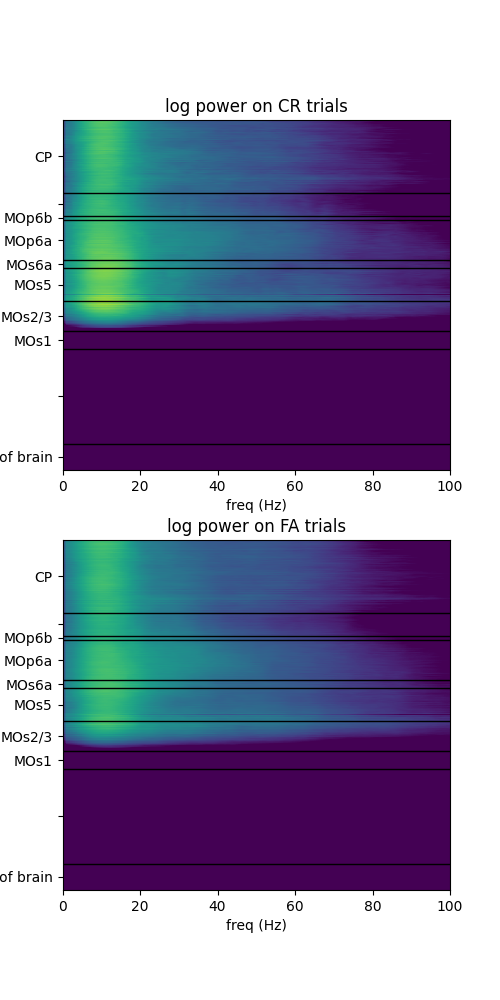

[Text(0, 344.0, 'CP'),
 Text(0, 291.5, ''),
 Text(0, 276.5, 'MOp6b'),
 Text(0, 252.0, 'MOp6a'),
 Text(0, 226.0, 'MOs6a'),
 Text(0, 203.5, 'MOs5'),
 Text(0, 168.5, 'MOs2/3'),
 Text(0, 142.5, 'MOs1'),
 Text(0, 81.0, ''),
 Text(0, 14.5, 'out of brain')]

In [46]:
fig,ax=plt.subplots(2,1,figsize=(5,10))

cr_im=ax[0].imshow(np.log10(CR_power).T,aspect='auto',vmin=np.log10(100),vmax=np.log10(7000),
                   extent=(sample_frequencies[0],sample_frequencies[-1],0,384))
ax[0].set_title('log power on CR trials')
ax[0].set_xlim([0,100])
ax[0].set_ylabel('channel')
ax[0].set_xlabel('freq (Hz)')

ax[0].hlines(384-area_borders,xmin=0,xmax=100,
                   color='k',linewidth=1)
ax[0].set_yticks(384-midpoints)
ax[0].set_yticklabels(area_labels)

fa_im=ax[1].imshow(np.log10(FA_power).T,aspect='auto',vmin=np.log10(100),vmax=np.log10(7000),
                   extent=(sample_frequencies[0],sample_frequencies[-1],0,384))
ax[1].set_title('log power on FA trials')
ax[1].set_xlim([0,100])
ax[1].set_ylabel('channel')
ax[1].set_xlabel('freq (Hz)')

ax[1].hlines(384-area_borders,xmin=0,xmax=100,
                   color='k',linewidth=1)
ax[1].set_yticks(384-midpoints)
ax[1].set_yticklabels(area_labels)

<IPython.core.display.Javascript object>


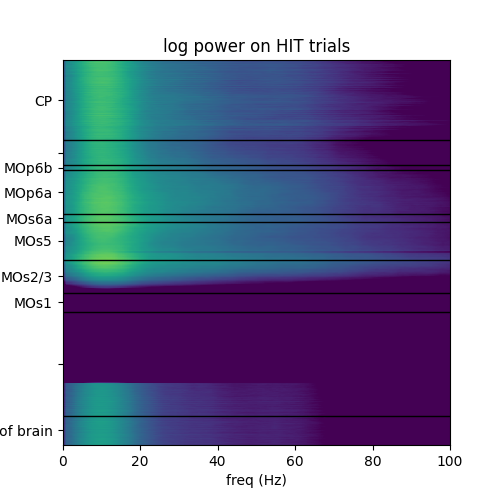

[Text(0, 344.0, 'CP'),
 Text(0, 291.5, ''),
 Text(0, 276.5, 'MOp6b'),
 Text(0, 252.0, 'MOp6a'),
 Text(0, 226.0, 'MOs6a'),
 Text(0, 203.5, 'MOs5'),
 Text(0, 168.5, 'MOs2/3'),
 Text(0, 142.5, 'MOs1'),
 Text(0, 81.0, ''),
 Text(0, 14.5, 'out of brain')]

In [19]:
fig,ax=plt.subplots(1,1,figsize=(5,5))

hit_im=ax.imshow(np.log10(HIT_power).T,aspect='auto',vmin=np.log10(100),vmax=np.log10(7000),
                   extent=(sample_frequencies[0],sample_frequencies[-1],0,384))
ax.set_title('log power on HIT trials')
ax.set_xlim([0,100])
ax.set_ylabel('channel')
ax.set_xlabel('freq (Hz)')

ax.hlines(384-area_borders,xmin=0,xmax=100,
                   color='k',linewidth=1)
ax.set_yticks(384-midpoints)
ax.set_yticklabels(area_labels)

<IPython.core.display.Javascript object>


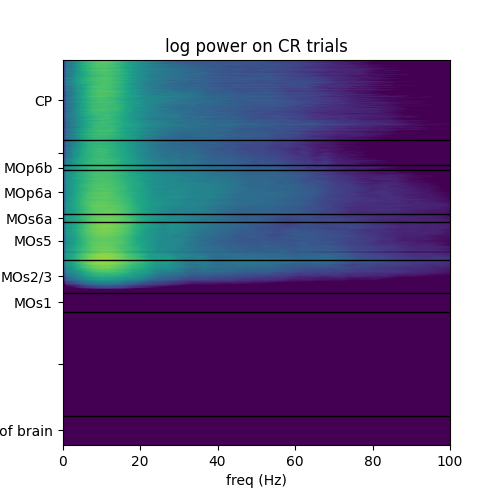

[Text(0, 344.0, 'CP'),
 Text(0, 291.5, ''),
 Text(0, 276.5, 'MOp6b'),
 Text(0, 252.0, 'MOp6a'),
 Text(0, 226.0, 'MOs6a'),
 Text(0, 203.5, 'MOs5'),
 Text(0, 168.5, 'MOs2/3'),
 Text(0, 142.5, 'MOs1'),
 Text(0, 81.0, ''),
 Text(0, 14.5, 'out of brain')]

In [47]:
fig,ax=plt.subplots(1,1,figsize=(5,5))

cr_im=ax.imshow(np.log10(CR_power).T,aspect='auto',vmin=np.log10(100),vmax=np.log10(7000),
                   extent=(sample_frequencies[0],sample_frequencies[-1],0,384))
ax.set_title('log power on CR trials')
ax.set_xlim([0,100])
ax.set_ylabel('channel')
ax.set_xlabel('freq (Hz)')

ax.hlines(384-area_borders,xmin=0,xmax=100,
                   color='k',linewidth=1)
ax.set_yticks(384-midpoints)
ax.set_yticklabels(area_labels)


<IPython.core.display.Javascript object>


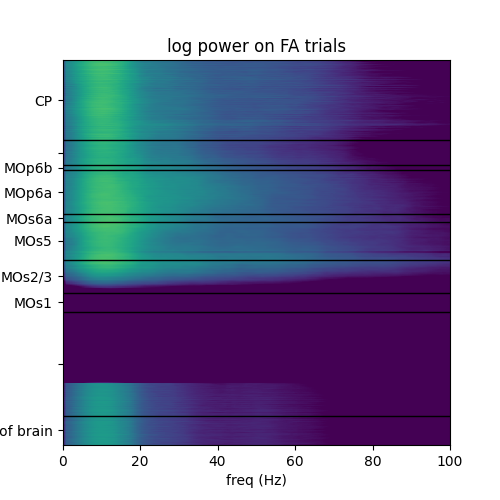

[Text(0, 344.0, 'CP'),
 Text(0, 291.5, ''),
 Text(0, 276.5, 'MOp6b'),
 Text(0, 252.0, 'MOp6a'),
 Text(0, 226.0, 'MOs6a'),
 Text(0, 203.5, 'MOs5'),
 Text(0, 168.5, 'MOs2/3'),
 Text(0, 142.5, 'MOs1'),
 Text(0, 81.0, ''),
 Text(0, 14.5, 'out of brain')]

In [21]:
fig,ax=plt.subplots(1,1,figsize=(5,5))

fa_im=ax.imshow(np.log10(FA_power).T,aspect='auto',vmin=np.log10(100),vmax=np.log10(7000),
                   extent=(sample_frequencies[0],sample_frequencies[-1],0,384))
ax.set_title('log power on FA trials')
ax.set_xlim([0,100])
ax.set_ylabel('channel')
ax.set_xlabel('freq (Hz)')

ax.hlines(384-area_borders,xmin=0,xmax=100,
                   color='k',linewidth=1)
ax.set_yticks(384-midpoints)
ax.set_yticklabels(area_labels)

<IPython.core.display.Javascript object>


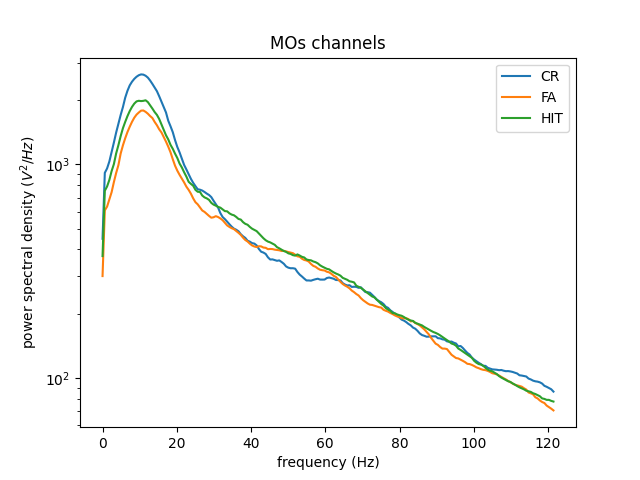

Text(0.5, 1.0, 'MOs channels')

In [48]:
fig,ax=plt.subplots(1,1)
ax.plot(sample_frequencies[:200],np.nanmedian(CR_power[:200,MOs_channels],1).T)
ax.plot(sample_frequencies[:200],np.nanmedian(FA_power[:200,MOs_channels],1).T)
ax.plot(sample_frequencies[:200],np.nanmedian(HIT_power[:200,MOs_channels],1).T)
ax.legend(['CR','FA','HIT'])

ax.set_yscale('log')
ax.set_xlabel('frequency (Hz)')
ax.set_ylabel('power spectral density ($V^{2}/Hz$)')
ax.set_title('MOs channels')

<IPython.core.display.Javascript object>


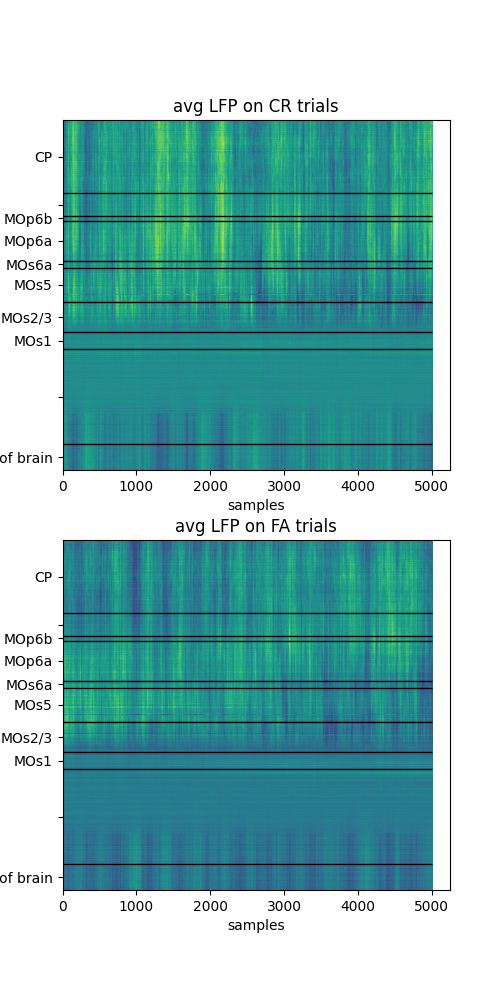

[Text(0, 40.0, 'CP'),
 Text(0, 92.5, ''),
 Text(0, 107.5, 'MOp6b'),
 Text(0, 132.0, 'MOp6a'),
 Text(0, 158.0, 'MOs6a'),
 Text(0, 180.5, 'MOs5'),
 Text(0, 215.5, 'MOs2/3'),
 Text(0, 241.5, 'MOs1'),
 Text(0, 303.0, ''),
 Text(0, 369.5, 'out of brain')]

In [37]:
fig,ax=plt.subplots(2,1,figsize=(5,10))

cr_im=ax[0].imshow(CR_lfp.T,aspect='auto')
ax[0].set_title('avg LFP on CR trials')
# ax[0].set_xlim([0,100])
ax[0].set_ylabel('channel')
ax[0].set_xlabel('samples')

ax[0].hlines(area_borders,xmin=0,xmax=5000,
                   color='k',linewidth=1)
ax[0].set_yticks(midpoints)
ax[0].set_yticklabels(area_labels)

fa_im=ax[1].imshow(FA_lfp.T,aspect='auto')
ax[1].set_title('avg LFP on FA trials')
# ax[1].set_xlim([0,100])
ax[1].set_ylabel('channel')
ax[1].set_xlabel('samples')

ax[1].hlines(area_borders,xmin=0,xmax=5000,
                   color='k',linewidth=1)
ax[1].set_yticks(midpoints)
ax[1].set_yticklabels(area_labels)

<IPython.core.display.Javascript object>


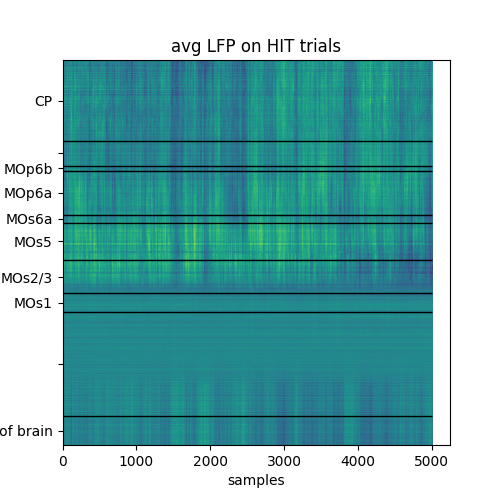

[Text(0, 40.0, 'CP'),
 Text(0, 92.5, ''),
 Text(0, 107.5, 'MOp6b'),
 Text(0, 132.0, 'MOp6a'),
 Text(0, 158.0, 'MOs6a'),
 Text(0, 180.5, 'MOs5'),
 Text(0, 215.5, 'MOs2/3'),
 Text(0, 241.5, 'MOs1'),
 Text(0, 303.0, ''),
 Text(0, 369.5, 'out of brain')]

In [38]:
fig,ax=plt.subplots(1,1,figsize=(5,5))

cr_im=ax.imshow(HIT_lfp.T,aspect='auto')
ax.set_title('avg LFP on HIT trials')
# ax[0].set_xlim([0,100])
ax.set_ylabel('channel')
ax.set_xlabel('samples')

ax.hlines(area_borders,xmin=0,xmax=5000,
                   color='k',linewidth=1)
ax.set_yticks(midpoints)
ax.set_yticklabels(area_labels)

<IPython.core.display.Javascript object>


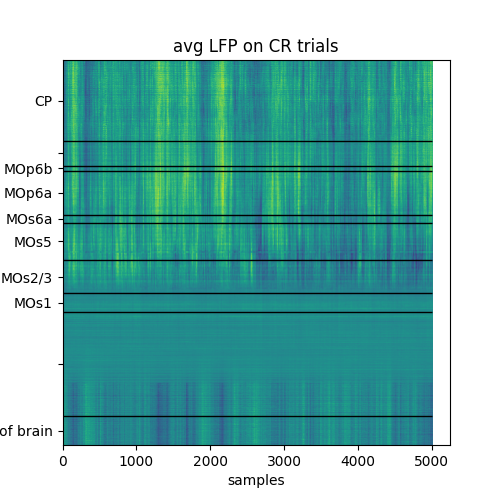

[Text(0, 40.0, 'CP'),
 Text(0, 92.5, ''),
 Text(0, 107.5, 'MOp6b'),
 Text(0, 132.0, 'MOp6a'),
 Text(0, 158.0, 'MOs6a'),
 Text(0, 180.5, 'MOs5'),
 Text(0, 215.5, 'MOs2/3'),
 Text(0, 241.5, 'MOs1'),
 Text(0, 303.0, ''),
 Text(0, 369.5, 'out of brain')]

In [39]:
fig,ax=plt.subplots(1,1,figsize=(5,5))

cr_im=ax.imshow(CR_lfp.T,aspect='auto')
ax.set_title('avg LFP on CR trials')
# ax[0].set_xlim([0,100])
ax.set_ylabel('channel')
ax.set_xlabel('samples')

ax.hlines(area_borders,xmin=0,xmax=5000,
                   color='k',linewidth=1)
ax.set_yticks(midpoints)
ax.set_yticklabels(area_labels)

<IPython.core.display.Javascript object>


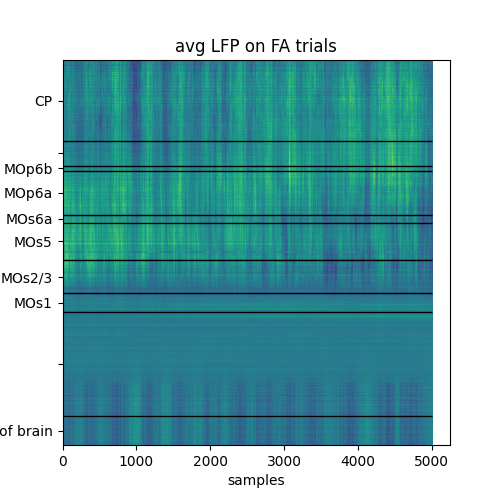

[Text(0, 40.0, 'CP'),
 Text(0, 92.5, ''),
 Text(0, 107.5, 'MOp6b'),
 Text(0, 132.0, 'MOp6a'),
 Text(0, 158.0, 'MOs6a'),
 Text(0, 180.5, 'MOs5'),
 Text(0, 215.5, 'MOs2/3'),
 Text(0, 241.5, 'MOs1'),
 Text(0, 303.0, ''),
 Text(0, 369.5, 'out of brain')]

In [40]:
fig,ax=plt.subplots(1,1,figsize=(5,5))

fa_im=ax.imshow(FA_lfp.T,aspect='auto')
ax.set_title('avg LFP on FA trials')
# ax[0].set_xlim([0,100])
ax.set_ylabel('channel')
ax.set_xlabel('samples')

ax.hlines(area_borders,xmin=0,xmax=5000,
                   color='k',linewidth=1)
ax.set_yticks(midpoints)
ax.set_yticklabels(area_labels)

<IPython.core.display.Javascript object>


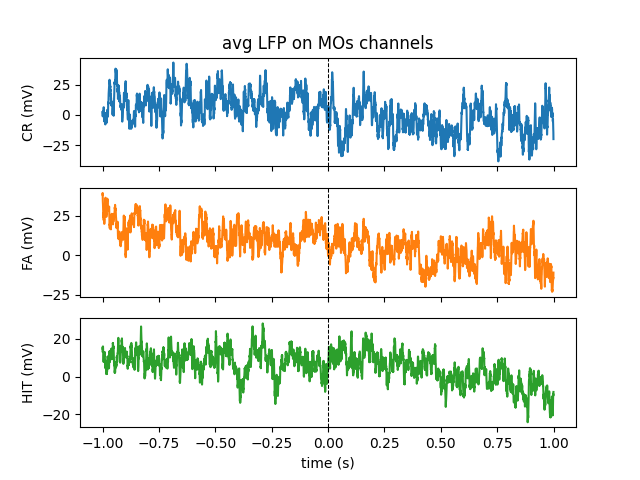

Text(0.5, 1.0, 'avg LFP on MOs channels')

In [41]:
tvect=np.arange(-1,1,1/2500)

fig,ax=plt.subplots(3,1,sharex=True)
ax[0].plot(tvect,np.nanmean(CR_lfp[:,MOs_channels],1).T*0.195)
ax[0].axvline(0,color='k',linewidth=0.75,linestyle='--')
ax[0].set_ylabel('CR (mV)')

ax[1].plot(tvect,np.nanmean(FA_lfp[:,MOs_channels],1).T*0.195,color='tab:orange')
ax[1].axvline(0,color='k',linewidth=0.75,linestyle='--')
ax[1].set_ylabel('FA (mV)')

ax[2].plot(tvect,np.nanmean(HIT_lfp[:,MOs_channels],1).T*0.195,color='tab:green')
ax[2].axvline(0,color='k',linewidth=0.75,linestyle='--')
ax[2].set_ylabel('HIT (mV)')

ax[2].set_xlabel('time (s)')

ax[0].set_title('avg LFP on MOs channels')

In [ ]:
np.min(FA_power)

In [ ]:
np.max(CR_power[:100,:])

In [ ]:
session.trials

In [ ]:
np.round(sample_frequency*4).astype('int')

In [ ]:
session.trials

In [ ]:

startPt = int(sample_frequency*0)
endPt = startPt + int(sample_frequency)

channel_range = [350,360]

nchannels=384
nfft=4096

channels = np.arange(nchannels).astype('int')

chunk = np.copy(lfp_signal[startPt:endPt,channels])

for ch in np.arange(nchannels):
    chunk[:,ch] = chunk[:,ch] - np.median(chunk[:,ch])

for ch in np.arange(nchannels):
    chunk[:,ch] = chunk[:,ch] - np.median(chunk[:,channel_range[0]:channel_range[1]],1)

power = np.zeros((int(nfft/2+1), nchannels))

for ch in np.arange(nchannels):

    sample_frequencies, Pxx_den = sg.welch(chunk[:,ch], fs=sample_frequency, nfft=nfft)
    power[:,ch] = Pxx_den

In [ ]:
# #re-reference to acsf channels

# ACSF_chans=np.arange(325,350)

# lfp_re_ref_ch=lfp_channel_ind[::4]
# lfp_re_ref=[]
# lfp_re_ref=np.zeros((lfp_signal.shape[0],lfp_re_ref_ch.shape[0]))

# ACSF_median=np.median(lfp_signal[:,ACSF_chans],1)

# for ich, ch in enumerate(lfp_re_ref_ch):
#     lfp_re_ref[:,ich]=(lfp_signal[:,ch]-ACSF_median)
    

In [ ]:
# for ich, ch in enumerate(lfp_re_ref_ch):
#     print('ich: ',ich)
#     print('ch: ',ch)

In [ ]:
start_t=0
end_t=60
time_axis=np.arange(start_t,end_t,1/2500)
plot_data=chunk
# plot_data=lfp_re_ref
# plot_data=lfp_signal

fig,ax=plt.subplots()
im=ax.imshow(plot_data[2500*start_t:2500*end_t,:].T,aspect='auto',
            extent=(start_t,end_t,plot_data.shape[1],0),vmin=-2000,vmax=2000)

fig.subplots_adjust(bottom=0.1, right=0.8, top=0.9, hspace=0.3)
cax = plt.axes([0.85, 0.1, 0.025, 0.8])
cbar = fig.colorbar(im, cax=cax)

In [ ]:
### need surface estimate to get ACSF channels

In [38]:
session.good_units['probe'].unique()

array(['A', 'B', 'C', 'D', 'E', 'F'], dtype=object)

In [78]:
# loop through sessions & probes

main_save_path=r'D:\DR\LFP analysis'

for sel_session in range(0,len(main_path)):
    
    t_start=time.time()
    
    session=Session(path=main_path[sel_session])
    session.assign_unit_areas()
    
    probes=session.good_units['probe'].unique()

    for probe in probes:
        
        if probe not in session.channels:
            continue
#         #check if areas of interest are on this probe
#         probe_areas=session.good_units.query('probe == @probe')['area_short'].unique()
#         if ~(('VIS' in probe_areas)|('MOs' in probe_areas)|('MOp in probe_areas')):
#             continue
        
        #get channel areas
        chans=session.channels[probe]
        session.channels[probe]['region'][session.channels[probe].query('region.isnull()').index.values]=''
        area_borders=np.where(chans['region'].iloc[:-1].values!=
                               chans['region'].iloc[1:].values)[0]
        all_edges=np.hstack([0,area_borders,len(chans)])
        midpoints=all_edges[:-1]+(all_edges[1:]-all_edges[:-1])/2
        area_labels=chans['region'].iloc[midpoints.astype('int')].values
        
        #load LFP timestamps
        lfp_path=session.metadata['syncData'][probe]['dirName'].replace('AP','LFP')
        lfp_samples_path=os.path.join(lfp_path,"sample_numbers.npy")
        lfp_samples=np.load(lfp_samples_path)
        lfp_samples=lfp_samples-np.min(lfp_samples)
        lfp_timestamps = lfp_samples/(session.metadata['syncData'][probe]['LFPsampleRate']) - session.metadata['syncData'][probe]['shift']

        #load LFP signal
        lfp_signal=np.memmap(os.path.join(lfp_path,'continuous.dat'),dtype='int16',mode='r')
        lfp_signal=np.reshape(lfp_signal, (int(lfp_signal.size / 384), 384))
        lfp_channel_ind=np.arange(0,384)
        sample_frequency = session.metadata['syncData'][probe]['LFPsampleRate']
        
        #load confirmed surface channels
        surface_channels=pd.read_csv(r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\DRpilot_surface_estimates.csv")
        
        #for every trial, extract & normalize LFP

        nchannels=384
        nfft=2**12

        channels = np.arange(nchannels).astype('int')

        #get surface channel for this session + probe
        mouse_session=str(session.metadata['mouseID'])+'_'+str(session.metadata['ephys_session_num'])
        probe_surface_channel = int(surface_channels.query('session ==  @mouse_session')['probe'+probe].values)+20

        lfp_tensor=np.zeros((1250,384,len(session.trials)),dtype='int16')
        power = np.zeros((int(nfft/2+1), nchannels, len(session.trials)))
        power[:]=np.nan

        pre_chunk = np.copy(lfp_signal[20*2500:50*2500,channels])
        pre_chunk_median = np.median(pre_chunk,0)
        pre_chunk = []

        #loop through all trials
        for tt, trial in session.trials.iterrows():
            startPt = int((trial['stimStartTime']-0.5)*sample_frequency)
            endPt = int(startPt + int(sample_frequency)*0.5)

            channel_range = [probe_surface_channel+20, 380]
            
            #subtract channel-by-channel median
            chunk = np.copy(lfp_signal[startPt:endPt,channels]) - pre_chunk_median
            
            #subtract median of agar channels
            chunk = (chunk.T - np.median(chunk[:,channel_range[0]:channel_range[1]],1).T).T
            
            for ch in np.arange(nchannels):
                sample_frequencies, Pxx_den = sg.welch(chunk[:,ch], fs=sample_frequency, nfft=nfft)
                if len(Pxx_den)==int(nfft/2+1):
                    power[:,ch,tt] = Pxx_den
            
            if chunk.shape==lfp_tensor[:,:,0].shape:
                lfp_tensor[:,:,tt]=chunk
                
            chunk=[]
            
            if tt % 10 == 0:
                print(mouse_session+' probe'+probe+' trial ',tt,' done')
               
        savepath=os.path.join(main_save_path,mouse_session)
        savename=mouse_session+'_'+probe
        
        if os.path.exists(savepath)==False:
            os.makedirs(savepath)
            
        np.save(os.path.join(savepath,'probe'+probe+'_lfp.npy'),lfp_tensor)
        np.save(os.path.join(savepath,'probe'+probe+'_power.npy'),power[:200,:,:])
        
    np.save(os.path.join(savepath,'sample_freqs.npy'),sample_frequencies[:200])
        
    t_elapsed=time.time()-t_start
    
    print('session '+mouse_session+' complete in '+str(np.round(t_elapsed/60,decimals=2))+' min')

probeA areas found
probeB areas found
probeC areas found
probeD areas found
probeE areas not found
probeF areas found


C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_21744\606650071.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.channels[probe]['region'][session.channels[probe].query('region.isnull()').index.values]=''


644866_2 probeA trial  0  done
644866_2 probeA trial  10  done
644866_2 probeA trial  20  done
644866_2 probeA trial  30  done
644866_2 probeA trial  40  done
644866_2 probeA trial  50  done
644866_2 probeA trial  60  done
644866_2 probeA trial  70  done
644866_2 probeA trial  80  done
644866_2 probeA trial  90  done
644866_2 probeA trial  100  done
644866_2 probeA trial  110  done
644866_2 probeA trial  120  done
644866_2 probeA trial  130  done
644866_2 probeA trial  140  done
644866_2 probeA trial  150  done
644866_2 probeA trial  160  done
644866_2 probeA trial  170  done
644866_2 probeA trial  180  done
644866_2 probeA trial  190  done
644866_2 probeA trial  200  done
644866_2 probeA trial  210  done
644866_2 probeA trial  220  done
644866_2 probeA trial  230  done
644866_2 probeA trial  240  done
644866_2 probeA trial  250  done
644866_2 probeA trial  260  done
644866_2 probeA trial  270  done
644866_2 probeA trial  280  done
644866_2 probeA trial  290  done
644866_2 probeA trial

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_21744\606650071.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.channels[probe]['region'][session.channels[probe].query('region.isnull()').index.values]=''


644866_2 probeB trial  0  done
644866_2 probeB trial  10  done
644866_2 probeB trial  20  done
644866_2 probeB trial  30  done
644866_2 probeB trial  40  done
644866_2 probeB trial  50  done
644866_2 probeB trial  60  done
644866_2 probeB trial  70  done
644866_2 probeB trial  80  done
644866_2 probeB trial  90  done
644866_2 probeB trial  100  done
644866_2 probeB trial  110  done
644866_2 probeB trial  120  done
644866_2 probeB trial  130  done
644866_2 probeB trial  140  done
644866_2 probeB trial  150  done
644866_2 probeB trial  160  done
644866_2 probeB trial  170  done
644866_2 probeB trial  180  done
644866_2 probeB trial  190  done
644866_2 probeB trial  200  done
644866_2 probeB trial  210  done
644866_2 probeB trial  220  done
644866_2 probeB trial  230  done
644866_2 probeB trial  240  done
644866_2 probeB trial  250  done
644866_2 probeB trial  260  done
644866_2 probeB trial  270  done
644866_2 probeB trial  280  done
644866_2 probeB trial  290  done
644866_2 probeB trial

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_21744\606650071.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.channels[probe]['region'][session.channels[probe].query('region.isnull()').index.values]=''


644866_2 probeC trial  0  done
644866_2 probeC trial  10  done
644866_2 probeC trial  20  done
644866_2 probeC trial  30  done
644866_2 probeC trial  40  done
644866_2 probeC trial  50  done
644866_2 probeC trial  60  done
644866_2 probeC trial  70  done
644866_2 probeC trial  80  done
644866_2 probeC trial  90  done
644866_2 probeC trial  100  done
644866_2 probeC trial  110  done
644866_2 probeC trial  120  done
644866_2 probeC trial  130  done
644866_2 probeC trial  140  done
644866_2 probeC trial  150  done
644866_2 probeC trial  160  done
644866_2 probeC trial  170  done
644866_2 probeC trial  180  done
644866_2 probeC trial  190  done
644866_2 probeC trial  200  done
644866_2 probeC trial  210  done
644866_2 probeC trial  220  done
644866_2 probeC trial  230  done
644866_2 probeC trial  240  done
644866_2 probeC trial  250  done
644866_2 probeC trial  260  done
644866_2 probeC trial  270  done
644866_2 probeC trial  280  done
644866_2 probeC trial  290  done
644866_2 probeC trial

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_21744\606650071.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.channels[probe]['region'][session.channels[probe].query('region.isnull()').index.values]=''


644866_2 probeD trial  0  done
644866_2 probeD trial  10  done
644866_2 probeD trial  20  done
644866_2 probeD trial  30  done
644866_2 probeD trial  40  done
644866_2 probeD trial  50  done
644866_2 probeD trial  60  done
644866_2 probeD trial  70  done
644866_2 probeD trial  80  done
644866_2 probeD trial  90  done
644866_2 probeD trial  100  done
644866_2 probeD trial  110  done
644866_2 probeD trial  120  done
644866_2 probeD trial  130  done
644866_2 probeD trial  140  done
644866_2 probeD trial  150  done
644866_2 probeD trial  160  done
644866_2 probeD trial  170  done
644866_2 probeD trial  180  done
644866_2 probeD trial  190  done
644866_2 probeD trial  200  done
644866_2 probeD trial  210  done
644866_2 probeD trial  220  done
644866_2 probeD trial  230  done
644866_2 probeD trial  240  done
644866_2 probeD trial  250  done
644866_2 probeD trial  260  done
644866_2 probeD trial  270  done
644866_2 probeD trial  280  done
644866_2 probeD trial  290  done
644866_2 probeD trial

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_21744\606650071.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.channels[probe]['region'][session.channels[probe].query('region.isnull()').index.values]=''


644866_2 probeF trial  0  done
644866_2 probeF trial  10  done
644866_2 probeF trial  20  done
644866_2 probeF trial  30  done
644866_2 probeF trial  40  done
644866_2 probeF trial  50  done
644866_2 probeF trial  60  done
644866_2 probeF trial  70  done
644866_2 probeF trial  80  done
644866_2 probeF trial  90  done
644866_2 probeF trial  100  done
644866_2 probeF trial  110  done
644866_2 probeF trial  120  done
644866_2 probeF trial  130  done
644866_2 probeF trial  140  done
644866_2 probeF trial  150  done
644866_2 probeF trial  160  done
644866_2 probeF trial  170  done
644866_2 probeF trial  180  done
644866_2 probeF trial  190  done
644866_2 probeF trial  200  done
644866_2 probeF trial  210  done
644866_2 probeF trial  220  done
644866_2 probeF trial  230  done
644866_2 probeF trial  240  done
644866_2 probeF trial  250  done
644866_2 probeF trial  260  done
644866_2 probeF trial  270  done
644866_2 probeF trial  280  done
644866_2 probeF trial  290  done
644866_2 probeF trial

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_21744\606650071.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.channels[probe]['region'][session.channels[probe].query('region.isnull()').index.values]=''


644866_3 probeA trial  0  done
644866_3 probeA trial  10  done
644866_3 probeA trial  20  done
644866_3 probeA trial  30  done
644866_3 probeA trial  40  done
644866_3 probeA trial  50  done
644866_3 probeA trial  60  done
644866_3 probeA trial  70  done
644866_3 probeA trial  80  done
644866_3 probeA trial  90  done
644866_3 probeA trial  100  done
644866_3 probeA trial  110  done
644866_3 probeA trial  120  done
644866_3 probeA trial  130  done
644866_3 probeA trial  140  done
644866_3 probeA trial  150  done
644866_3 probeA trial  160  done
644866_3 probeA trial  170  done
644866_3 probeA trial  180  done
644866_3 probeA trial  190  done
644866_3 probeA trial  200  done
644866_3 probeA trial  210  done
644866_3 probeA trial  220  done
644866_3 probeA trial  230  done
644866_3 probeA trial  240  done
644866_3 probeA trial  250  done
644866_3 probeA trial  260  done
644866_3 probeA trial  270  done
644866_3 probeA trial  280  done
644866_3 probeA trial  290  done
644866_3 probeA trial

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_21744\606650071.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.channels[probe]['region'][session.channels[probe].query('region.isnull()').index.values]=''


644866_3 probeB trial  0  done
644866_3 probeB trial  10  done
644866_3 probeB trial  20  done
644866_3 probeB trial  30  done
644866_3 probeB trial  40  done
644866_3 probeB trial  50  done
644866_3 probeB trial  60  done
644866_3 probeB trial  70  done
644866_3 probeB trial  80  done
644866_3 probeB trial  90  done
644866_3 probeB trial  100  done
644866_3 probeB trial  110  done
644866_3 probeB trial  120  done
644866_3 probeB trial  130  done
644866_3 probeB trial  140  done
644866_3 probeB trial  150  done
644866_3 probeB trial  160  done
644866_3 probeB trial  170  done
644866_3 probeB trial  180  done
644866_3 probeB trial  190  done
644866_3 probeB trial  200  done
644866_3 probeB trial  210  done
644866_3 probeB trial  220  done
644866_3 probeB trial  230  done
644866_3 probeB trial  240  done
644866_3 probeB trial  250  done
644866_3 probeB trial  260  done
644866_3 probeB trial  270  done
644866_3 probeB trial  280  done
644866_3 probeB trial  290  done
644866_3 probeB trial

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_21744\606650071.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.channels[probe]['region'][session.channels[probe].query('region.isnull()').index.values]=''


644866_3 probeC trial  0  done
644866_3 probeC trial  10  done
644866_3 probeC trial  20  done
644866_3 probeC trial  30  done
644866_3 probeC trial  40  done
644866_3 probeC trial  50  done
644866_3 probeC trial  60  done
644866_3 probeC trial  70  done
644866_3 probeC trial  80  done
644866_3 probeC trial  90  done
644866_3 probeC trial  100  done
644866_3 probeC trial  110  done
644866_3 probeC trial  120  done
644866_3 probeC trial  130  done
644866_3 probeC trial  140  done
644866_3 probeC trial  150  done
644866_3 probeC trial  160  done
644866_3 probeC trial  170  done
644866_3 probeC trial  180  done
644866_3 probeC trial  190  done
644866_3 probeC trial  200  done
644866_3 probeC trial  210  done
644866_3 probeC trial  220  done
644866_3 probeC trial  230  done
644866_3 probeC trial  240  done
644866_3 probeC trial  250  done
644866_3 probeC trial  260  done
644866_3 probeC trial  270  done
644866_3 probeC trial  280  done
644866_3 probeC trial  290  done
644866_3 probeC trial

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_21744\606650071.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.channels[probe]['region'][session.channels[probe].query('region.isnull()').index.values]=''


644866_3 probeD trial  0  done
644866_3 probeD trial  10  done
644866_3 probeD trial  20  done
644866_3 probeD trial  30  done
644866_3 probeD trial  40  done
644866_3 probeD trial  50  done
644866_3 probeD trial  60  done
644866_3 probeD trial  70  done
644866_3 probeD trial  80  done
644866_3 probeD trial  90  done
644866_3 probeD trial  100  done
644866_3 probeD trial  110  done
644866_3 probeD trial  120  done
644866_3 probeD trial  130  done
644866_3 probeD trial  140  done
644866_3 probeD trial  150  done
644866_3 probeD trial  160  done
644866_3 probeD trial  170  done
644866_3 probeD trial  180  done
644866_3 probeD trial  190  done
644866_3 probeD trial  200  done
644866_3 probeD trial  210  done
644866_3 probeD trial  220  done
644866_3 probeD trial  230  done
644866_3 probeD trial  240  done
644866_3 probeD trial  250  done
644866_3 probeD trial  260  done
644866_3 probeD trial  270  done
644866_3 probeD trial  280  done
644866_3 probeD trial  290  done
644866_3 probeD trial

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_21744\606650071.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.channels[probe]['region'][session.channels[probe].query('region.isnull()').index.values]=''


644866_3 probeE trial  0  done
644866_3 probeE trial  10  done
644866_3 probeE trial  20  done
644866_3 probeE trial  30  done
644866_3 probeE trial  40  done
644866_3 probeE trial  50  done
644866_3 probeE trial  60  done
644866_3 probeE trial  70  done
644866_3 probeE trial  80  done
644866_3 probeE trial  90  done
644866_3 probeE trial  100  done
644866_3 probeE trial  110  done
644866_3 probeE trial  120  done
644866_3 probeE trial  130  done
644866_3 probeE trial  140  done
644866_3 probeE trial  150  done
644866_3 probeE trial  160  done
644866_3 probeE trial  170  done
644866_3 probeE trial  180  done
644866_3 probeE trial  190  done
644866_3 probeE trial  200  done
644866_3 probeE trial  210  done
644866_3 probeE trial  220  done
644866_3 probeE trial  230  done
644866_3 probeE trial  240  done
644866_3 probeE trial  250  done
644866_3 probeE trial  260  done
644866_3 probeE trial  270  done
644866_3 probeE trial  280  done
644866_3 probeE trial  290  done
644866_3 probeE trial

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_21744\606650071.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.channels[probe]['region'][session.channels[probe].query('region.isnull()').index.values]=''


644866_3 probeF trial  0  done
644866_3 probeF trial  10  done
644866_3 probeF trial  20  done
644866_3 probeF trial  30  done
644866_3 probeF trial  40  done
644866_3 probeF trial  50  done
644866_3 probeF trial  60  done
644866_3 probeF trial  70  done
644866_3 probeF trial  80  done
644866_3 probeF trial  90  done
644866_3 probeF trial  100  done
644866_3 probeF trial  110  done
644866_3 probeF trial  120  done
644866_3 probeF trial  130  done
644866_3 probeF trial  140  done
644866_3 probeF trial  150  done
644866_3 probeF trial  160  done
644866_3 probeF trial  170  done
644866_3 probeF trial  180  done
644866_3 probeF trial  190  done
644866_3 probeF trial  200  done
644866_3 probeF trial  210  done
644866_3 probeF trial  220  done
644866_3 probeF trial  230  done
644866_3 probeF trial  240  done
644866_3 probeF trial  250  done
644866_3 probeF trial  260  done
644866_3 probeF trial  270  done
644866_3 probeF trial  280  done
644866_3 probeF trial  290  done
644866_3 probeF trial

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_21744\606650071.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.channels[probe]['region'][session.channels[probe].query('region.isnull()').index.values]=''


644866_4 probeA trial  0  done
644866_4 probeA trial  10  done
644866_4 probeA trial  20  done
644866_4 probeA trial  30  done
644866_4 probeA trial  40  done
644866_4 probeA trial  50  done
644866_4 probeA trial  60  done
644866_4 probeA trial  70  done
644866_4 probeA trial  80  done
644866_4 probeA trial  90  done
644866_4 probeA trial  100  done
644866_4 probeA trial  110  done
644866_4 probeA trial  120  done
644866_4 probeA trial  130  done
644866_4 probeA trial  140  done
644866_4 probeA trial  150  done
644866_4 probeA trial  160  done
644866_4 probeA trial  170  done
644866_4 probeA trial  180  done
644866_4 probeA trial  190  done
644866_4 probeA trial  200  done
644866_4 probeA trial  210  done
644866_4 probeA trial  220  done
644866_4 probeA trial  230  done
644866_4 probeA trial  240  done
644866_4 probeA trial  250  done
644866_4 probeA trial  260  done
644866_4 probeA trial  270  done
644866_4 probeA trial  280  done
644866_4 probeA trial  290  done
644866_4 probeA trial

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_21744\606650071.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.channels[probe]['region'][session.channels[probe].query('region.isnull()').index.values]=''


644866_4 probeB trial  0  done
644866_4 probeB trial  10  done
644866_4 probeB trial  20  done
644866_4 probeB trial  30  done
644866_4 probeB trial  40  done
644866_4 probeB trial  50  done
644866_4 probeB trial  60  done
644866_4 probeB trial  70  done
644866_4 probeB trial  80  done
644866_4 probeB trial  90  done
644866_4 probeB trial  100  done
644866_4 probeB trial  110  done
644866_4 probeB trial  120  done
644866_4 probeB trial  130  done
644866_4 probeB trial  140  done
644866_4 probeB trial  150  done
644866_4 probeB trial  160  done
644866_4 probeB trial  170  done
644866_4 probeB trial  180  done
644866_4 probeB trial  190  done
644866_4 probeB trial  200  done
644866_4 probeB trial  210  done
644866_4 probeB trial  220  done
644866_4 probeB trial  230  done
644866_4 probeB trial  240  done
644866_4 probeB trial  250  done
644866_4 probeB trial  260  done
644866_4 probeB trial  270  done
644866_4 probeB trial  280  done
644866_4 probeB trial  290  done
644866_4 probeB trial

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_21744\606650071.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.channels[probe]['region'][session.channels[probe].query('region.isnull()').index.values]=''


644866_4 probeC trial  0  done
644866_4 probeC trial  10  done
644866_4 probeC trial  20  done
644866_4 probeC trial  30  done
644866_4 probeC trial  40  done
644866_4 probeC trial  50  done
644866_4 probeC trial  60  done
644866_4 probeC trial  70  done
644866_4 probeC trial  80  done
644866_4 probeC trial  90  done
644866_4 probeC trial  100  done
644866_4 probeC trial  110  done
644866_4 probeC trial  120  done
644866_4 probeC trial  130  done
644866_4 probeC trial  140  done
644866_4 probeC trial  150  done
644866_4 probeC trial  160  done
644866_4 probeC trial  170  done
644866_4 probeC trial  180  done
644866_4 probeC trial  190  done
644866_4 probeC trial  200  done
644866_4 probeC trial  210  done
644866_4 probeC trial  220  done
644866_4 probeC trial  230  done
644866_4 probeC trial  240  done
644866_4 probeC trial  250  done
644866_4 probeC trial  260  done
644866_4 probeC trial  270  done
644866_4 probeC trial  280  done
644866_4 probeC trial  290  done
644866_4 probeC trial

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_21744\606650071.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.channels[probe]['region'][session.channels[probe].query('region.isnull()').index.values]=''


644866_4 probeD trial  0  done
644866_4 probeD trial  10  done
644866_4 probeD trial  20  done
644866_4 probeD trial  30  done
644866_4 probeD trial  40  done
644866_4 probeD trial  50  done
644866_4 probeD trial  60  done
644866_4 probeD trial  70  done
644866_4 probeD trial  80  done
644866_4 probeD trial  90  done
644866_4 probeD trial  100  done
644866_4 probeD trial  110  done
644866_4 probeD trial  120  done
644866_4 probeD trial  130  done
644866_4 probeD trial  140  done
644866_4 probeD trial  150  done
644866_4 probeD trial  160  done
644866_4 probeD trial  170  done
644866_4 probeD trial  180  done
644866_4 probeD trial  190  done
644866_4 probeD trial  200  done
644866_4 probeD trial  210  done
644866_4 probeD trial  220  done
644866_4 probeD trial  230  done
644866_4 probeD trial  240  done
644866_4 probeD trial  250  done
644866_4 probeD trial  260  done
644866_4 probeD trial  270  done
644866_4 probeD trial  280  done
644866_4 probeD trial  290  done
644866_4 probeD trial

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_21744\606650071.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.channels[probe]['region'][session.channels[probe].query('region.isnull()').index.values]=''


644866_4 probeE trial  0  done
644866_4 probeE trial  10  done
644866_4 probeE trial  20  done
644866_4 probeE trial  30  done
644866_4 probeE trial  40  done
644866_4 probeE trial  50  done
644866_4 probeE trial  60  done
644866_4 probeE trial  70  done
644866_4 probeE trial  80  done
644866_4 probeE trial  90  done
644866_4 probeE trial  100  done
644866_4 probeE trial  110  done
644866_4 probeE trial  120  done
644866_4 probeE trial  130  done
644866_4 probeE trial  140  done
644866_4 probeE trial  150  done
644866_4 probeE trial  160  done
644866_4 probeE trial  170  done
644866_4 probeE trial  180  done
644866_4 probeE trial  190  done
644866_4 probeE trial  200  done
644866_4 probeE trial  210  done
644866_4 probeE trial  220  done
644866_4 probeE trial  230  done
644866_4 probeE trial  240  done
644866_4 probeE trial  250  done
644866_4 probeE trial  260  done
644866_4 probeE trial  270  done
644866_4 probeE trial  280  done
644866_4 probeE trial  290  done
644866_4 probeE trial

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_21744\606650071.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.channels[probe]['region'][session.channels[probe].query('region.isnull()').index.values]=''
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


644867_1 probeA trial  0  done
644867_1 probeA trial  10  done
644867_1 probeA trial  20  done
644867_1 probeA trial  30  done
644867_1 probeA trial  40  done
644867_1 probeA trial  50  done
644867_1 probeA trial  60  done
644867_1 probeA trial  70  done
644867_1 probeA trial  80  done
644867_1 probeA trial  90  done
644867_1 probeA trial  100  done
644867_1 probeA trial  110  done
644867_1 probeA trial  120  done
644867_1 probeA trial  130  done
644867_1 probeA trial  140  done
644867_1 probeA trial  150  done
644867_1 probeA trial  160  done
644867_1 probeA trial  170  done
644867_1 probeA trial  180  done
644867_1 probeA trial  190  done
644867_1 probeA trial  200  done
644867_1 probeA trial  210  done
644867_1 probeA trial  220  done
644867_1 probeA trial  230  done
644867_1 probeA trial  240  done
644867_1 probeA trial  250  done
644867_1 probeA trial  260  done
644867_1 probeA trial  270  done
644867_1 probeA trial  280  done
644867_1 probeA trial  290  done
644867_1 probeA trial

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_21744\606650071.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.channels[probe]['region'][session.channels[probe].query('region.isnull()').index.values]=''
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


644867_1 probeB trial  0  done
644867_1 probeB trial  10  done
644867_1 probeB trial  20  done
644867_1 probeB trial  30  done
644867_1 probeB trial  40  done
644867_1 probeB trial  50  done
644867_1 probeB trial  60  done
644867_1 probeB trial  70  done
644867_1 probeB trial  80  done
644867_1 probeB trial  90  done
644867_1 probeB trial  100  done
644867_1 probeB trial  110  done
644867_1 probeB trial  120  done
644867_1 probeB trial  130  done
644867_1 probeB trial  140  done
644867_1 probeB trial  150  done
644867_1 probeB trial  160  done
644867_1 probeB trial  170  done
644867_1 probeB trial  180  done
644867_1 probeB trial  190  done
644867_1 probeB trial  200  done
644867_1 probeB trial  210  done
644867_1 probeB trial  220  done
644867_1 probeB trial  230  done
644867_1 probeB trial  240  done
644867_1 probeB trial  250  done
644867_1 probeB trial  260  done
644867_1 probeB trial  270  done
644867_1 probeB trial  280  done
644867_1 probeB trial  290  done
644867_1 probeB trial

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_21744\606650071.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.channels[probe]['region'][session.channels[probe].query('region.isnull()').index.values]=''
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


644867_1 probeC trial  0  done
644867_1 probeC trial  10  done
644867_1 probeC trial  20  done
644867_1 probeC trial  30  done
644867_1 probeC trial  40  done
644867_1 probeC trial  50  done
644867_1 probeC trial  60  done
644867_1 probeC trial  70  done
644867_1 probeC trial  80  done
644867_1 probeC trial  90  done
644867_1 probeC trial  100  done
644867_1 probeC trial  110  done
644867_1 probeC trial  120  done
644867_1 probeC trial  130  done
644867_1 probeC trial  140  done
644867_1 probeC trial  150  done
644867_1 probeC trial  160  done
644867_1 probeC trial  170  done
644867_1 probeC trial  180  done
644867_1 probeC trial  190  done
644867_1 probeC trial  200  done
644867_1 probeC trial  210  done
644867_1 probeC trial  220  done
644867_1 probeC trial  230  done
644867_1 probeC trial  240  done
644867_1 probeC trial  250  done
644867_1 probeC trial  260  done
644867_1 probeC trial  270  done
644867_1 probeC trial  280  done
644867_1 probeC trial  290  done
644867_1 probeC trial

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_21744\606650071.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.channels[probe]['region'][session.channels[probe].query('region.isnull()').index.values]=''
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


644867_1 probeD trial  0  done
644867_1 probeD trial  10  done
644867_1 probeD trial  20  done
644867_1 probeD trial  30  done
644867_1 probeD trial  40  done
644867_1 probeD trial  50  done
644867_1 probeD trial  60  done
644867_1 probeD trial  70  done
644867_1 probeD trial  80  done
644867_1 probeD trial  90  done
644867_1 probeD trial  100  done
644867_1 probeD trial  110  done
644867_1 probeD trial  120  done
644867_1 probeD trial  130  done
644867_1 probeD trial  140  done
644867_1 probeD trial  150  done
644867_1 probeD trial  160  done
644867_1 probeD trial  170  done
644867_1 probeD trial  180  done
644867_1 probeD trial  190  done
644867_1 probeD trial  200  done
644867_1 probeD trial  210  done
644867_1 probeD trial  220  done
644867_1 probeD trial  230  done
644867_1 probeD trial  240  done
644867_1 probeD trial  250  done
644867_1 probeD trial  260  done
644867_1 probeD trial  270  done
644867_1 probeD trial  280  done
644867_1 probeD trial  290  done
644867_1 probeD trial

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_21744\606650071.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.channels[probe]['region'][session.channels[probe].query('region.isnull()').index.values]=''


644867_1 probeE trial  0  done
644867_1 probeE trial  10  done
644867_1 probeE trial  20  done
644867_1 probeE trial  30  done
644867_1 probeE trial  40  done
644867_1 probeE trial  50  done
644867_1 probeE trial  60  done
644867_1 probeE trial  70  done
644867_1 probeE trial  80  done
644867_1 probeE trial  90  done
644867_1 probeE trial  100  done
644867_1 probeE trial  110  done
644867_1 probeE trial  120  done
644867_1 probeE trial  130  done
644867_1 probeE trial  140  done
644867_1 probeE trial  150  done
644867_1 probeE trial  160  done
644867_1 probeE trial  170  done
644867_1 probeE trial  180  done
644867_1 probeE trial  190  done
644867_1 probeE trial  200  done
644867_1 probeE trial  210  done
644867_1 probeE trial  220  done
644867_1 probeE trial  230  done
644867_1 probeE trial  240  done
644867_1 probeE trial  250  done
644867_1 probeE trial  260  done
644867_1 probeE trial  270  done
644867_1 probeE trial  280  done
644867_1 probeE trial  290  done
644867_1 probeE trial

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_21744\606650071.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.channels[probe]['region'][session.channels[probe].query('region.isnull()').index.values]=''


644867_1 probeF trial  0  done
644867_1 probeF trial  10  done
644867_1 probeF trial  20  done
644867_1 probeF trial  30  done
644867_1 probeF trial  40  done
644867_1 probeF trial  50  done
644867_1 probeF trial  60  done
644867_1 probeF trial  70  done
644867_1 probeF trial  80  done
644867_1 probeF trial  90  done
644867_1 probeF trial  100  done
644867_1 probeF trial  110  done
644867_1 probeF trial  120  done
644867_1 probeF trial  130  done
644867_1 probeF trial  140  done
644867_1 probeF trial  150  done
644867_1 probeF trial  160  done
644867_1 probeF trial  170  done
644867_1 probeF trial  180  done
644867_1 probeF trial  190  done
644867_1 probeF trial  200  done
644867_1 probeF trial  210  done
644867_1 probeF trial  220  done
644867_1 probeF trial  230  done
644867_1 probeF trial  240  done
644867_1 probeF trial  250  done
644867_1 probeF trial  260  done
644867_1 probeF trial  270  done
644867_1 probeF trial  280  done
644867_1 probeF trial  290  done
644867_1 probeF trial

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_21744\606650071.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.channels[probe]['region'][session.channels[probe].query('region.isnull()').index.values]=''


644867_2 probeA trial  0  done
644867_2 probeA trial  10  done
644867_2 probeA trial  20  done
644867_2 probeA trial  30  done
644867_2 probeA trial  40  done
644867_2 probeA trial  50  done
644867_2 probeA trial  60  done
644867_2 probeA trial  70  done
644867_2 probeA trial  80  done
644867_2 probeA trial  90  done
644867_2 probeA trial  100  done
644867_2 probeA trial  110  done
644867_2 probeA trial  120  done
644867_2 probeA trial  130  done
644867_2 probeA trial  140  done
644867_2 probeA trial  150  done
644867_2 probeA trial  160  done
644867_2 probeA trial  170  done
644867_2 probeA trial  180  done
644867_2 probeA trial  190  done
644867_2 probeA trial  200  done
644867_2 probeA trial  210  done
644867_2 probeA trial  220  done
644867_2 probeA trial  230  done
644867_2 probeA trial  240  done
644867_2 probeA trial  250  done
644867_2 probeA trial  260  done
644867_2 probeA trial  270  done
644867_2 probeA trial  280  done
644867_2 probeA trial  290  done
644867_2 probeA trial

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_21744\606650071.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.channels[probe]['region'][session.channels[probe].query('region.isnull()').index.values]=''


644867_2 probeB trial  0  done
644867_2 probeB trial  10  done
644867_2 probeB trial  20  done
644867_2 probeB trial  30  done
644867_2 probeB trial  40  done
644867_2 probeB trial  50  done
644867_2 probeB trial  60  done
644867_2 probeB trial  70  done
644867_2 probeB trial  80  done
644867_2 probeB trial  90  done
644867_2 probeB trial  100  done
644867_2 probeB trial  110  done
644867_2 probeB trial  120  done
644867_2 probeB trial  130  done
644867_2 probeB trial  140  done
644867_2 probeB trial  150  done
644867_2 probeB trial  160  done
644867_2 probeB trial  170  done
644867_2 probeB trial  180  done
644867_2 probeB trial  190  done
644867_2 probeB trial  200  done
644867_2 probeB trial  210  done
644867_2 probeB trial  220  done
644867_2 probeB trial  230  done
644867_2 probeB trial  240  done
644867_2 probeB trial  250  done
644867_2 probeB trial  260  done
644867_2 probeB trial  270  done
644867_2 probeB trial  280  done
644867_2 probeB trial  290  done
644867_2 probeB trial

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_21744\606650071.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.channels[probe]['region'][session.channels[probe].query('region.isnull()').index.values]=''
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


644867_2 probeC trial  0  done
644867_2 probeC trial  10  done
644867_2 probeC trial  20  done
644867_2 probeC trial  30  done
644867_2 probeC trial  40  done
644867_2 probeC trial  50  done
644867_2 probeC trial  60  done
644867_2 probeC trial  70  done
644867_2 probeC trial  80  done
644867_2 probeC trial  90  done
644867_2 probeC trial  100  done
644867_2 probeC trial  110  done
644867_2 probeC trial  120  done
644867_2 probeC trial  130  done
644867_2 probeC trial  140  done
644867_2 probeC trial  150  done
644867_2 probeC trial  160  done
644867_2 probeC trial  170  done
644867_2 probeC trial  180  done
644867_2 probeC trial  190  done
644867_2 probeC trial  200  done
644867_2 probeC trial  210  done
644867_2 probeC trial  220  done
644867_2 probeC trial  230  done
644867_2 probeC trial  240  done
644867_2 probeC trial  250  done
644867_2 probeC trial  260  done
644867_2 probeC trial  270  done
644867_2 probeC trial  280  done
644867_2 probeC trial  290  done
644867_2 probeC trial

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_21744\606650071.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.channels[probe]['region'][session.channels[probe].query('region.isnull()').index.values]=''


644867_2 probeD trial  0  done
644867_2 probeD trial  10  done
644867_2 probeD trial  20  done
644867_2 probeD trial  30  done
644867_2 probeD trial  40  done
644867_2 probeD trial  50  done
644867_2 probeD trial  60  done
644867_2 probeD trial  70  done
644867_2 probeD trial  80  done
644867_2 probeD trial  90  done
644867_2 probeD trial  100  done
644867_2 probeD trial  110  done
644867_2 probeD trial  120  done
644867_2 probeD trial  130  done
644867_2 probeD trial  140  done
644867_2 probeD trial  150  done
644867_2 probeD trial  160  done
644867_2 probeD trial  170  done
644867_2 probeD trial  180  done
644867_2 probeD trial  190  done
644867_2 probeD trial  200  done
644867_2 probeD trial  210  done
644867_2 probeD trial  220  done
644867_2 probeD trial  230  done
644867_2 probeD trial  240  done
644867_2 probeD trial  250  done
644867_2 probeD trial  260  done
644867_2 probeD trial  270  done
644867_2 probeD trial  280  done
644867_2 probeD trial  290  done
644867_2 probeD trial

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_21744\606650071.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.channels[probe]['region'][session.channels[probe].query('region.isnull()').index.values]=''
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


644867_2 probeE trial  0  done
644867_2 probeE trial  10  done
644867_2 probeE trial  20  done
644867_2 probeE trial  30  done
644867_2 probeE trial  40  done
644867_2 probeE trial  50  done
644867_2 probeE trial  60  done
644867_2 probeE trial  70  done
644867_2 probeE trial  80  done
644867_2 probeE trial  90  done
644867_2 probeE trial  100  done
644867_2 probeE trial  110  done
644867_2 probeE trial  120  done
644867_2 probeE trial  130  done
644867_2 probeE trial  140  done
644867_2 probeE trial  150  done
644867_2 probeE trial  160  done
644867_2 probeE trial  170  done
644867_2 probeE trial  180  done
644867_2 probeE trial  190  done
644867_2 probeE trial  200  done
644867_2 probeE trial  210  done
644867_2 probeE trial  220  done
644867_2 probeE trial  230  done
644867_2 probeE trial  240  done
644867_2 probeE trial  250  done
644867_2 probeE trial  260  done
644867_2 probeE trial  270  done
644867_2 probeE trial  280  done
644867_2 probeE trial  290  done
644867_2 probeE trial

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_21744\606650071.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.channels[probe]['region'][session.channels[probe].query('region.isnull()').index.values]=''


644867_2 probeF trial  0  done
644867_2 probeF trial  10  done
644867_2 probeF trial  20  done
644867_2 probeF trial  30  done
644867_2 probeF trial  40  done
644867_2 probeF trial  50  done
644867_2 probeF trial  60  done
644867_2 probeF trial  70  done
644867_2 probeF trial  80  done
644867_2 probeF trial  90  done
644867_2 probeF trial  100  done
644867_2 probeF trial  110  done
644867_2 probeF trial  120  done
644867_2 probeF trial  130  done
644867_2 probeF trial  140  done
644867_2 probeF trial  150  done
644867_2 probeF trial  160  done
644867_2 probeF trial  170  done
644867_2 probeF trial  180  done
644867_2 probeF trial  190  done
644867_2 probeF trial  200  done
644867_2 probeF trial  210  done
644867_2 probeF trial  220  done
644867_2 probeF trial  230  done
644867_2 probeF trial  240  done
644867_2 probeF trial  250  done
644867_2 probeF trial  260  done
644867_2 probeF trial  270  done
644867_2 probeF trial  280  done
644867_2 probeF trial  290  done
644867_2 probeF trial

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_21744\606650071.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.channels[probe]['region'][session.channels[probe].query('region.isnull()').index.values]=''


644867_3 probeA trial  0  done
644867_3 probeA trial  10  done
644867_3 probeA trial  20  done
644867_3 probeA trial  30  done
644867_3 probeA trial  40  done
644867_3 probeA trial  50  done
644867_3 probeA trial  60  done
644867_3 probeA trial  70  done
644867_3 probeA trial  80  done
644867_3 probeA trial  90  done
644867_3 probeA trial  100  done
644867_3 probeA trial  110  done
644867_3 probeA trial  120  done
644867_3 probeA trial  130  done
644867_3 probeA trial  140  done
644867_3 probeA trial  150  done
644867_3 probeA trial  160  done
644867_3 probeA trial  170  done
644867_3 probeA trial  180  done
644867_3 probeA trial  190  done
644867_3 probeA trial  200  done
644867_3 probeA trial  210  done
644867_3 probeA trial  220  done
644867_3 probeA trial  230  done
644867_3 probeA trial  240  done
644867_3 probeA trial  250  done
644867_3 probeA trial  260  done
644867_3 probeA trial  270  done
644867_3 probeA trial  280  done
644867_3 probeA trial  290  done
644867_3 probeA trial

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_21744\606650071.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.channels[probe]['region'][session.channels[probe].query('region.isnull()').index.values]=''


644867_3 probeB trial  0  done
644867_3 probeB trial  10  done
644867_3 probeB trial  20  done
644867_3 probeB trial  30  done
644867_3 probeB trial  40  done
644867_3 probeB trial  50  done
644867_3 probeB trial  60  done
644867_3 probeB trial  70  done
644867_3 probeB trial  80  done
644867_3 probeB trial  90  done
644867_3 probeB trial  100  done
644867_3 probeB trial  110  done
644867_3 probeB trial  120  done
644867_3 probeB trial  130  done
644867_3 probeB trial  140  done
644867_3 probeB trial  150  done
644867_3 probeB trial  160  done
644867_3 probeB trial  170  done
644867_3 probeB trial  180  done
644867_3 probeB trial  190  done
644867_3 probeB trial  200  done
644867_3 probeB trial  210  done
644867_3 probeB trial  220  done
644867_3 probeB trial  230  done
644867_3 probeB trial  240  done
644867_3 probeB trial  250  done
644867_3 probeB trial  260  done
644867_3 probeB trial  270  done
644867_3 probeB trial  280  done
644867_3 probeB trial  290  done
644867_3 probeB trial

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_21744\606650071.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.channels[probe]['region'][session.channels[probe].query('region.isnull()').index.values]=''


644867_3 probeC trial  0  done
644867_3 probeC trial  10  done
644867_3 probeC trial  20  done
644867_3 probeC trial  30  done
644867_3 probeC trial  40  done
644867_3 probeC trial  50  done
644867_3 probeC trial  60  done
644867_3 probeC trial  70  done
644867_3 probeC trial  80  done
644867_3 probeC trial  90  done
644867_3 probeC trial  100  done
644867_3 probeC trial  110  done
644867_3 probeC trial  120  done
644867_3 probeC trial  130  done
644867_3 probeC trial  140  done
644867_3 probeC trial  150  done
644867_3 probeC trial  160  done
644867_3 probeC trial  170  done
644867_3 probeC trial  180  done
644867_3 probeC trial  190  done
644867_3 probeC trial  200  done
644867_3 probeC trial  210  done
644867_3 probeC trial  220  done
644867_3 probeC trial  230  done
644867_3 probeC trial  240  done
644867_3 probeC trial  250  done
644867_3 probeC trial  260  done
644867_3 probeC trial  270  done
644867_3 probeC trial  280  done
644867_3 probeC trial  290  done
644867_3 probeC trial

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_21744\606650071.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.channels[probe]['region'][session.channels[probe].query('region.isnull()').index.values]=''


644867_3 probeD trial  0  done
644867_3 probeD trial  10  done
644867_3 probeD trial  20  done
644867_3 probeD trial  30  done
644867_3 probeD trial  40  done
644867_3 probeD trial  50  done
644867_3 probeD trial  60  done
644867_3 probeD trial  70  done
644867_3 probeD trial  80  done
644867_3 probeD trial  90  done
644867_3 probeD trial  100  done
644867_3 probeD trial  110  done
644867_3 probeD trial  120  done
644867_3 probeD trial  130  done
644867_3 probeD trial  140  done
644867_3 probeD trial  150  done
644867_3 probeD trial  160  done
644867_3 probeD trial  170  done
644867_3 probeD trial  180  done
644867_3 probeD trial  190  done
644867_3 probeD trial  200  done
644867_3 probeD trial  210  done
644867_3 probeD trial  220  done
644867_3 probeD trial  230  done
644867_3 probeD trial  240  done
644867_3 probeD trial  250  done
644867_3 probeD trial  260  done
644867_3 probeD trial  270  done
644867_3 probeD trial  280  done
644867_3 probeD trial  290  done
644867_3 probeD trial

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_21744\606650071.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.channels[probe]['region'][session.channels[probe].query('region.isnull()').index.values]=''


644867_3 probeE trial  0  done
644867_3 probeE trial  10  done
644867_3 probeE trial  20  done
644867_3 probeE trial  30  done
644867_3 probeE trial  40  done
644867_3 probeE trial  50  done
644867_3 probeE trial  60  done
644867_3 probeE trial  70  done
644867_3 probeE trial  80  done
644867_3 probeE trial  90  done
644867_3 probeE trial  100  done
644867_3 probeE trial  110  done
644867_3 probeE trial  120  done
644867_3 probeE trial  130  done
644867_3 probeE trial  140  done
644867_3 probeE trial  150  done
644867_3 probeE trial  160  done
644867_3 probeE trial  170  done
644867_3 probeE trial  180  done
644867_3 probeE trial  190  done
644867_3 probeE trial  200  done
644867_3 probeE trial  210  done
644867_3 probeE trial  220  done
644867_3 probeE trial  230  done
644867_3 probeE trial  240  done
644867_3 probeE trial  250  done
644867_3 probeE trial  260  done
644867_3 probeE trial  270  done
644867_3 probeE trial  280  done
644867_3 probeE trial  290  done
644867_3 probeE trial

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_21744\606650071.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.channels[probe]['region'][session.channels[probe].query('region.isnull()').index.values]=''


644867_3 probeF trial  0  done
644867_3 probeF trial  10  done
644867_3 probeF trial  20  done
644867_3 probeF trial  30  done
644867_3 probeF trial  40  done
644867_3 probeF trial  50  done
644867_3 probeF trial  60  done
644867_3 probeF trial  70  done
644867_3 probeF trial  80  done
644867_3 probeF trial  90  done
644867_3 probeF trial  100  done
644867_3 probeF trial  110  done
644867_3 probeF trial  120  done
644867_3 probeF trial  130  done
644867_3 probeF trial  140  done
644867_3 probeF trial  150  done
644867_3 probeF trial  160  done
644867_3 probeF trial  170  done
644867_3 probeF trial  180  done
644867_3 probeF trial  190  done
644867_3 probeF trial  200  done
644867_3 probeF trial  210  done
644867_3 probeF trial  220  done
644867_3 probeF trial  230  done
644867_3 probeF trial  240  done
644867_3 probeF trial  250  done
644867_3 probeF trial  260  done
644867_3 probeF trial  270  done
644867_3 probeF trial  280  done
644867_3 probeF trial  290  done
644867_3 probeF trial

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_21744\606650071.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.channels[probe]['region'][session.channels[probe].query('region.isnull()').index.values]=''


644867_4 probeA trial  0  done
644867_4 probeA trial  10  done
644867_4 probeA trial  20  done
644867_4 probeA trial  30  done
644867_4 probeA trial  40  done
644867_4 probeA trial  50  done
644867_4 probeA trial  60  done
644867_4 probeA trial  70  done
644867_4 probeA trial  80  done
644867_4 probeA trial  90  done
644867_4 probeA trial  100  done
644867_4 probeA trial  110  done
644867_4 probeA trial  120  done
644867_4 probeA trial  130  done
644867_4 probeA trial  140  done
644867_4 probeA trial  150  done
644867_4 probeA trial  160  done
644867_4 probeA trial  170  done
644867_4 probeA trial  180  done
644867_4 probeA trial  190  done
644867_4 probeA trial  200  done
644867_4 probeA trial  210  done
644867_4 probeA trial  220  done
644867_4 probeA trial  230  done
644867_4 probeA trial  240  done
644867_4 probeA trial  250  done
644867_4 probeA trial  260  done
644867_4 probeA trial  270  done
644867_4 probeA trial  280  done
644867_4 probeA trial  290  done
644867_4 probeA trial

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_21744\606650071.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.channels[probe]['region'][session.channels[probe].query('region.isnull()').index.values]=''
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


644867_4 probeB trial  0  done
644867_4 probeB trial  10  done
644867_4 probeB trial  20  done
644867_4 probeB trial  30  done
644867_4 probeB trial  40  done
644867_4 probeB trial  50  done
644867_4 probeB trial  60  done
644867_4 probeB trial  70  done
644867_4 probeB trial  80  done
644867_4 probeB trial  90  done
644867_4 probeB trial  100  done
644867_4 probeB trial  110  done
644867_4 probeB trial  120  done
644867_4 probeB trial  130  done
644867_4 probeB trial  140  done
644867_4 probeB trial  150  done
644867_4 probeB trial  160  done
644867_4 probeB trial  170  done
644867_4 probeB trial  180  done
644867_4 probeB trial  190  done
644867_4 probeB trial  200  done
644867_4 probeB trial  210  done
644867_4 probeB trial  220  done
644867_4 probeB trial  230  done
644867_4 probeB trial  240  done
644867_4 probeB trial  250  done
644867_4 probeB trial  260  done
644867_4 probeB trial  270  done
644867_4 probeB trial  280  done
644867_4 probeB trial  290  done
644867_4 probeB trial

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_21744\606650071.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.channels[probe]['region'][session.channels[probe].query('region.isnull()').index.values]=''


644867_4 probeC trial  0  done
644867_4 probeC trial  10  done
644867_4 probeC trial  20  done
644867_4 probeC trial  30  done
644867_4 probeC trial  40  done
644867_4 probeC trial  50  done
644867_4 probeC trial  60  done
644867_4 probeC trial  70  done
644867_4 probeC trial  80  done
644867_4 probeC trial  90  done
644867_4 probeC trial  100  done
644867_4 probeC trial  110  done
644867_4 probeC trial  120  done
644867_4 probeC trial  130  done
644867_4 probeC trial  140  done
644867_4 probeC trial  150  done
644867_4 probeC trial  160  done
644867_4 probeC trial  170  done
644867_4 probeC trial  180  done
644867_4 probeC trial  190  done
644867_4 probeC trial  200  done
644867_4 probeC trial  210  done
644867_4 probeC trial  220  done
644867_4 probeC trial  230  done
644867_4 probeC trial  240  done
644867_4 probeC trial  250  done
644867_4 probeC trial  260  done
644867_4 probeC trial  270  done
644867_4 probeC trial  280  done
644867_4 probeC trial  290  done
644867_4 probeC trial

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_21744\606650071.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.channels[probe]['region'][session.channels[probe].query('region.isnull()').index.values]=''
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


644867_4 probeD trial  0  done
644867_4 probeD trial  10  done
644867_4 probeD trial  20  done
644867_4 probeD trial  30  done
644867_4 probeD trial  40  done
644867_4 probeD trial  50  done
644867_4 probeD trial  60  done
644867_4 probeD trial  70  done
644867_4 probeD trial  80  done
644867_4 probeD trial  90  done
644867_4 probeD trial  100  done
644867_4 probeD trial  110  done
644867_4 probeD trial  120  done
644867_4 probeD trial  130  done
644867_4 probeD trial  140  done
644867_4 probeD trial  150  done
644867_4 probeD trial  160  done
644867_4 probeD trial  170  done
644867_4 probeD trial  180  done
644867_4 probeD trial  190  done
644867_4 probeD trial  200  done
644867_4 probeD trial  210  done
644867_4 probeD trial  220  done
644867_4 probeD trial  230  done
644867_4 probeD trial  240  done
644867_4 probeD trial  250  done
644867_4 probeD trial  260  done
644867_4 probeD trial  270  done
644867_4 probeD trial  280  done
644867_4 probeD trial  290  done
644867_4 probeD trial

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_21744\606650071.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.channels[probe]['region'][session.channels[probe].query('region.isnull()').index.values]=''


644867_4 probeE trial  0  done
644867_4 probeE trial  10  done
644867_4 probeE trial  20  done
644867_4 probeE trial  30  done
644867_4 probeE trial  40  done
644867_4 probeE trial  50  done
644867_4 probeE trial  60  done
644867_4 probeE trial  70  done
644867_4 probeE trial  80  done
644867_4 probeE trial  90  done
644867_4 probeE trial  100  done
644867_4 probeE trial  110  done
644867_4 probeE trial  120  done
644867_4 probeE trial  130  done
644867_4 probeE trial  140  done
644867_4 probeE trial  150  done
644867_4 probeE trial  160  done
644867_4 probeE trial  170  done
644867_4 probeE trial  180  done
644867_4 probeE trial  190  done
644867_4 probeE trial  200  done
644867_4 probeE trial  210  done
644867_4 probeE trial  220  done
644867_4 probeE trial  230  done
644867_4 probeE trial  240  done
644867_4 probeE trial  250  done
644867_4 probeE trial  260  done
644867_4 probeE trial  270  done
644867_4 probeE trial  280  done
644867_4 probeE trial  290  done
644867_4 probeE trial

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_21744\606650071.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.channels[probe]['region'][session.channels[probe].query('region.isnull()').index.values]=''


644867_4 probeF trial  0  done
644867_4 probeF trial  10  done
644867_4 probeF trial  20  done
644867_4 probeF trial  30  done
644867_4 probeF trial  40  done
644867_4 probeF trial  50  done
644867_4 probeF trial  60  done
644867_4 probeF trial  70  done
644867_4 probeF trial  80  done
644867_4 probeF trial  90  done
644867_4 probeF trial  100  done
644867_4 probeF trial  110  done
644867_4 probeF trial  120  done
644867_4 probeF trial  130  done
644867_4 probeF trial  140  done
644867_4 probeF trial  150  done
644867_4 probeF trial  160  done
644867_4 probeF trial  170  done
644867_4 probeF trial  180  done
644867_4 probeF trial  190  done
644867_4 probeF trial  200  done
644867_4 probeF trial  210  done
644867_4 probeF trial  220  done
644867_4 probeF trial  230  done
644867_4 probeF trial  240  done
644867_4 probeF trial  250  done
644867_4 probeF trial  260  done
644867_4 probeF trial  270  done
644867_4 probeF trial  280  done
644867_4 probeF trial  290  done
644867_4 probeF trial

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_21744\606650071.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.channels[probe]['region'][session.channels[probe].query('region.isnull()').index.values]=''


649943_1 probeA trial  0  done
649943_1 probeA trial  10  done
649943_1 probeA trial  20  done
649943_1 probeA trial  30  done
649943_1 probeA trial  40  done
649943_1 probeA trial  50  done
649943_1 probeA trial  60  done
649943_1 probeA trial  70  done
649943_1 probeA trial  80  done
649943_1 probeA trial  90  done
649943_1 probeA trial  100  done
649943_1 probeA trial  110  done
649943_1 probeA trial  120  done
649943_1 probeA trial  130  done
649943_1 probeA trial  140  done
649943_1 probeA trial  150  done
649943_1 probeA trial  160  done
649943_1 probeA trial  170  done
649943_1 probeA trial  180  done
649943_1 probeA trial  190  done
649943_1 probeA trial  200  done
649943_1 probeA trial  210  done
649943_1 probeA trial  220  done
649943_1 probeA trial  230  done
649943_1 probeA trial  240  done
649943_1 probeA trial  250  done
649943_1 probeA trial  260  done
649943_1 probeA trial  270  done
649943_1 probeA trial  280  done
649943_1 probeA trial  290  done
649943_1 probeA trial

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_21744\606650071.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.channels[probe]['region'][session.channels[probe].query('region.isnull()').index.values]=''


649943_1 probeB trial  0  done
649943_1 probeB trial  10  done
649943_1 probeB trial  20  done
649943_1 probeB trial  30  done
649943_1 probeB trial  40  done
649943_1 probeB trial  50  done
649943_1 probeB trial  60  done
649943_1 probeB trial  70  done
649943_1 probeB trial  80  done
649943_1 probeB trial  90  done
649943_1 probeB trial  100  done
649943_1 probeB trial  110  done
649943_1 probeB trial  120  done
649943_1 probeB trial  130  done
649943_1 probeB trial  140  done
649943_1 probeB trial  150  done
649943_1 probeB trial  160  done
649943_1 probeB trial  170  done
649943_1 probeB trial  180  done
649943_1 probeB trial  190  done
649943_1 probeB trial  200  done
649943_1 probeB trial  210  done
649943_1 probeB trial  220  done
649943_1 probeB trial  230  done
649943_1 probeB trial  240  done
649943_1 probeB trial  250  done
649943_1 probeB trial  260  done
649943_1 probeB trial  270  done
649943_1 probeB trial  280  done
649943_1 probeB trial  290  done
649943_1 probeB trial

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_21744\606650071.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.channels[probe]['region'][session.channels[probe].query('region.isnull()').index.values]=''


649943_1 probeC trial  0  done
649943_1 probeC trial  10  done
649943_1 probeC trial  20  done
649943_1 probeC trial  30  done
649943_1 probeC trial  40  done
649943_1 probeC trial  50  done
649943_1 probeC trial  60  done
649943_1 probeC trial  70  done
649943_1 probeC trial  80  done
649943_1 probeC trial  90  done
649943_1 probeC trial  100  done
649943_1 probeC trial  110  done
649943_1 probeC trial  120  done
649943_1 probeC trial  130  done
649943_1 probeC trial  140  done
649943_1 probeC trial  150  done
649943_1 probeC trial  160  done
649943_1 probeC trial  170  done
649943_1 probeC trial  180  done
649943_1 probeC trial  190  done
649943_1 probeC trial  200  done
649943_1 probeC trial  210  done
649943_1 probeC trial  220  done
649943_1 probeC trial  230  done
649943_1 probeC trial  240  done
649943_1 probeC trial  250  done
649943_1 probeC trial  260  done
649943_1 probeC trial  270  done
649943_1 probeC trial  280  done
649943_1 probeC trial  290  done
649943_1 probeC trial

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_21744\606650071.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.channels[probe]['region'][session.channels[probe].query('region.isnull()').index.values]=''


649943_1 probeD trial  0  done
649943_1 probeD trial  10  done
649943_1 probeD trial  20  done
649943_1 probeD trial  30  done
649943_1 probeD trial  40  done
649943_1 probeD trial  50  done
649943_1 probeD trial  60  done
649943_1 probeD trial  70  done
649943_1 probeD trial  80  done
649943_1 probeD trial  90  done
649943_1 probeD trial  100  done
649943_1 probeD trial  110  done
649943_1 probeD trial  120  done
649943_1 probeD trial  130  done
649943_1 probeD trial  140  done
649943_1 probeD trial  150  done
649943_1 probeD trial  160  done
649943_1 probeD trial  170  done
649943_1 probeD trial  180  done
649943_1 probeD trial  190  done
649943_1 probeD trial  200  done
649943_1 probeD trial  210  done
649943_1 probeD trial  220  done
649943_1 probeD trial  230  done
649943_1 probeD trial  240  done
649943_1 probeD trial  250  done
649943_1 probeD trial  260  done
649943_1 probeD trial  270  done
649943_1 probeD trial  280  done
649943_1 probeD trial  290  done
649943_1 probeD trial

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_21744\606650071.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.channels[probe]['region'][session.channels[probe].query('region.isnull()').index.values]=''


649943_1 probeE trial  0  done
649943_1 probeE trial  10  done
649943_1 probeE trial  20  done
649943_1 probeE trial  30  done
649943_1 probeE trial  40  done
649943_1 probeE trial  50  done
649943_1 probeE trial  60  done
649943_1 probeE trial  70  done
649943_1 probeE trial  80  done
649943_1 probeE trial  90  done
649943_1 probeE trial  100  done
649943_1 probeE trial  110  done
649943_1 probeE trial  120  done
649943_1 probeE trial  130  done
649943_1 probeE trial  140  done
649943_1 probeE trial  150  done
649943_1 probeE trial  160  done
649943_1 probeE trial  170  done
649943_1 probeE trial  180  done
649943_1 probeE trial  190  done
649943_1 probeE trial  200  done
649943_1 probeE trial  210  done
649943_1 probeE trial  220  done
649943_1 probeE trial  230  done
649943_1 probeE trial  240  done
649943_1 probeE trial  250  done
649943_1 probeE trial  260  done
649943_1 probeE trial  270  done
649943_1 probeE trial  280  done
649943_1 probeE trial  290  done
649943_1 probeE trial

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_21744\606650071.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.channels[probe]['region'][session.channels[probe].query('region.isnull()').index.values]=''


649943_1 probeF trial  0  done
649943_1 probeF trial  10  done
649943_1 probeF trial  20  done
649943_1 probeF trial  30  done
649943_1 probeF trial  40  done
649943_1 probeF trial  50  done
649943_1 probeF trial  60  done
649943_1 probeF trial  70  done
649943_1 probeF trial  80  done
649943_1 probeF trial  90  done
649943_1 probeF trial  100  done
649943_1 probeF trial  110  done
649943_1 probeF trial  120  done
649943_1 probeF trial  130  done
649943_1 probeF trial  140  done
649943_1 probeF trial  150  done
649943_1 probeF trial  160  done
649943_1 probeF trial  170  done
649943_1 probeF trial  180  done
649943_1 probeF trial  190  done
649943_1 probeF trial  200  done
649943_1 probeF trial  210  done
649943_1 probeF trial  220  done
649943_1 probeF trial  230  done
649943_1 probeF trial  240  done
649943_1 probeF trial  250  done
649943_1 probeF trial  260  done
649943_1 probeF trial  270  done
649943_1 probeF trial  280  done
649943_1 probeF trial  290  done
649943_1 probeF trial

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_21744\606650071.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.channels[probe]['region'][session.channels[probe].query('region.isnull()').index.values]=''


649943_2 probeA trial  0  done
649943_2 probeA trial  10  done
649943_2 probeA trial  20  done
649943_2 probeA trial  30  done
649943_2 probeA trial  40  done
649943_2 probeA trial  50  done
649943_2 probeA trial  60  done
649943_2 probeA trial  70  done
649943_2 probeA trial  80  done
649943_2 probeA trial  90  done
649943_2 probeA trial  100  done
649943_2 probeA trial  110  done
649943_2 probeA trial  120  done
649943_2 probeA trial  130  done
649943_2 probeA trial  140  done
649943_2 probeA trial  150  done
649943_2 probeA trial  160  done
649943_2 probeA trial  170  done
649943_2 probeA trial  180  done
649943_2 probeA trial  190  done
649943_2 probeA trial  200  done
649943_2 probeA trial  210  done
649943_2 probeA trial  220  done
649943_2 probeA trial  230  done
649943_2 probeA trial  240  done
649943_2 probeA trial  250  done
649943_2 probeA trial  260  done
649943_2 probeA trial  270  done
649943_2 probeA trial  280  done
649943_2 probeA trial  290  done
649943_2 probeA trial

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_21744\606650071.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.channels[probe]['region'][session.channels[probe].query('region.isnull()').index.values]=''


649943_2 probeB trial  0  done
649943_2 probeB trial  10  done
649943_2 probeB trial  20  done
649943_2 probeB trial  30  done
649943_2 probeB trial  40  done
649943_2 probeB trial  50  done
649943_2 probeB trial  60  done
649943_2 probeB trial  70  done
649943_2 probeB trial  80  done
649943_2 probeB trial  90  done
649943_2 probeB trial  100  done
649943_2 probeB trial  110  done
649943_2 probeB trial  120  done
649943_2 probeB trial  130  done
649943_2 probeB trial  140  done
649943_2 probeB trial  150  done
649943_2 probeB trial  160  done
649943_2 probeB trial  170  done
649943_2 probeB trial  180  done
649943_2 probeB trial  190  done
649943_2 probeB trial  200  done
649943_2 probeB trial  210  done
649943_2 probeB trial  220  done
649943_2 probeB trial  230  done
649943_2 probeB trial  240  done
649943_2 probeB trial  250  done
649943_2 probeB trial  260  done
649943_2 probeB trial  270  done
649943_2 probeB trial  280  done
649943_2 probeB trial  290  done
649943_2 probeB trial

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_21744\606650071.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.channels[probe]['region'][session.channels[probe].query('region.isnull()').index.values]=''


649943_2 probeC trial  0  done
649943_2 probeC trial  10  done
649943_2 probeC trial  20  done
649943_2 probeC trial  30  done
649943_2 probeC trial  40  done
649943_2 probeC trial  50  done
649943_2 probeC trial  60  done
649943_2 probeC trial  70  done
649943_2 probeC trial  80  done
649943_2 probeC trial  90  done
649943_2 probeC trial  100  done
649943_2 probeC trial  110  done
649943_2 probeC trial  120  done
649943_2 probeC trial  130  done
649943_2 probeC trial  140  done
649943_2 probeC trial  150  done
649943_2 probeC trial  160  done
649943_2 probeC trial  170  done
649943_2 probeC trial  180  done
649943_2 probeC trial  190  done
649943_2 probeC trial  200  done
649943_2 probeC trial  210  done
649943_2 probeC trial  220  done
649943_2 probeC trial  230  done
649943_2 probeC trial  240  done
649943_2 probeC trial  250  done
649943_2 probeC trial  260  done
649943_2 probeC trial  270  done
649943_2 probeC trial  280  done
649943_2 probeC trial  290  done
649943_2 probeC trial

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_21744\606650071.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.channels[probe]['region'][session.channels[probe].query('region.isnull()').index.values]=''


649943_2 probeD trial  0  done
649943_2 probeD trial  10  done
649943_2 probeD trial  20  done
649943_2 probeD trial  30  done
649943_2 probeD trial  40  done
649943_2 probeD trial  50  done
649943_2 probeD trial  60  done
649943_2 probeD trial  70  done
649943_2 probeD trial  80  done
649943_2 probeD trial  90  done
649943_2 probeD trial  100  done
649943_2 probeD trial  110  done
649943_2 probeD trial  120  done
649943_2 probeD trial  130  done
649943_2 probeD trial  140  done
649943_2 probeD trial  150  done
649943_2 probeD trial  160  done
649943_2 probeD trial  170  done
649943_2 probeD trial  180  done
649943_2 probeD trial  190  done
649943_2 probeD trial  200  done
649943_2 probeD trial  210  done
649943_2 probeD trial  220  done
649943_2 probeD trial  230  done
649943_2 probeD trial  240  done
649943_2 probeD trial  250  done
649943_2 probeD trial  260  done
649943_2 probeD trial  270  done
649943_2 probeD trial  280  done
649943_2 probeD trial  290  done
649943_2 probeD trial

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_21744\606650071.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.channels[probe]['region'][session.channels[probe].query('region.isnull()').index.values]=''


649943_2 probeE trial  0  done
649943_2 probeE trial  10  done
649943_2 probeE trial  20  done
649943_2 probeE trial  30  done
649943_2 probeE trial  40  done
649943_2 probeE trial  50  done
649943_2 probeE trial  60  done
649943_2 probeE trial  70  done
649943_2 probeE trial  80  done
649943_2 probeE trial  90  done
649943_2 probeE trial  100  done
649943_2 probeE trial  110  done
649943_2 probeE trial  120  done
649943_2 probeE trial  130  done
649943_2 probeE trial  140  done
649943_2 probeE trial  150  done
649943_2 probeE trial  160  done
649943_2 probeE trial  170  done
649943_2 probeE trial  180  done
649943_2 probeE trial  190  done
649943_2 probeE trial  200  done
649943_2 probeE trial  210  done
649943_2 probeE trial  220  done
649943_2 probeE trial  230  done
649943_2 probeE trial  240  done
649943_2 probeE trial  250  done
649943_2 probeE trial  260  done
649943_2 probeE trial  270  done
649943_2 probeE trial  280  done
649943_2 probeE trial  290  done
649943_2 probeE trial

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_21744\606650071.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.channels[probe]['region'][session.channels[probe].query('region.isnull()').index.values]=''


649943_2 probeF trial  0  done
649943_2 probeF trial  10  done
649943_2 probeF trial  20  done
649943_2 probeF trial  30  done
649943_2 probeF trial  40  done
649943_2 probeF trial  50  done
649943_2 probeF trial  60  done
649943_2 probeF trial  70  done
649943_2 probeF trial  80  done
649943_2 probeF trial  90  done
649943_2 probeF trial  100  done
649943_2 probeF trial  110  done
649943_2 probeF trial  120  done
649943_2 probeF trial  130  done
649943_2 probeF trial  140  done
649943_2 probeF trial  150  done
649943_2 probeF trial  160  done
649943_2 probeF trial  170  done
649943_2 probeF trial  180  done
649943_2 probeF trial  190  done
649943_2 probeF trial  200  done
649943_2 probeF trial  210  done
649943_2 probeF trial  220  done
649943_2 probeF trial  230  done
649943_2 probeF trial  240  done
649943_2 probeF trial  250  done
649943_2 probeF trial  260  done
649943_2 probeF trial  270  done
649943_2 probeF trial  280  done
649943_2 probeF trial  290  done
649943_2 probeF trial

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_21744\606650071.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.channels[probe]['region'][session.channels[probe].query('region.isnull()').index.values]=''


649943_3 probeA trial  0  done
649943_3 probeA trial  10  done
649943_3 probeA trial  20  done
649943_3 probeA trial  30  done
649943_3 probeA trial  40  done
649943_3 probeA trial  50  done
649943_3 probeA trial  60  done
649943_3 probeA trial  70  done
649943_3 probeA trial  80  done
649943_3 probeA trial  90  done
649943_3 probeA trial  100  done
649943_3 probeA trial  110  done
649943_3 probeA trial  120  done
649943_3 probeA trial  130  done
649943_3 probeA trial  140  done
649943_3 probeA trial  150  done
649943_3 probeA trial  160  done
649943_3 probeA trial  170  done
649943_3 probeA trial  180  done
649943_3 probeA trial  190  done
649943_3 probeA trial  200  done
649943_3 probeA trial  210  done
649943_3 probeA trial  220  done
649943_3 probeA trial  230  done
649943_3 probeA trial  240  done
649943_3 probeA trial  250  done
649943_3 probeA trial  260  done
649943_3 probeA trial  270  done
649943_3 probeA trial  280  done
649943_3 probeA trial  290  done
649943_3 probeA trial

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_21744\606650071.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.channels[probe]['region'][session.channels[probe].query('region.isnull()').index.values]=''


649943_3 probeB trial  0  done
649943_3 probeB trial  10  done
649943_3 probeB trial  20  done
649943_3 probeB trial  30  done
649943_3 probeB trial  40  done
649943_3 probeB trial  50  done
649943_3 probeB trial  60  done
649943_3 probeB trial  70  done
649943_3 probeB trial  80  done
649943_3 probeB trial  90  done
649943_3 probeB trial  100  done
649943_3 probeB trial  110  done
649943_3 probeB trial  120  done
649943_3 probeB trial  130  done
649943_3 probeB trial  140  done
649943_3 probeB trial  150  done
649943_3 probeB trial  160  done
649943_3 probeB trial  170  done
649943_3 probeB trial  180  done
649943_3 probeB trial  190  done
649943_3 probeB trial  200  done
649943_3 probeB trial  210  done
649943_3 probeB trial  220  done
649943_3 probeB trial  230  done
649943_3 probeB trial  240  done
649943_3 probeB trial  250  done
649943_3 probeB trial  260  done
649943_3 probeB trial  270  done
649943_3 probeB trial  280  done
649943_3 probeB trial  290  done
649943_3 probeB trial

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_21744\606650071.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.channels[probe]['region'][session.channels[probe].query('region.isnull()').index.values]=''
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


649943_3 probeC trial  0  done
649943_3 probeC trial  10  done
649943_3 probeC trial  20  done
649943_3 probeC trial  30  done
649943_3 probeC trial  40  done
649943_3 probeC trial  50  done
649943_3 probeC trial  60  done
649943_3 probeC trial  70  done
649943_3 probeC trial  80  done
649943_3 probeC trial  90  done
649943_3 probeC trial  100  done
649943_3 probeC trial  110  done
649943_3 probeC trial  120  done
649943_3 probeC trial  130  done
649943_3 probeC trial  140  done
649943_3 probeC trial  150  done
649943_3 probeC trial  160  done
649943_3 probeC trial  170  done
649943_3 probeC trial  180  done
649943_3 probeC trial  190  done
649943_3 probeC trial  200  done
649943_3 probeC trial  210  done
649943_3 probeC trial  220  done
649943_3 probeC trial  230  done
649943_3 probeC trial  240  done
649943_3 probeC trial  250  done
649943_3 probeC trial  260  done
649943_3 probeC trial  270  done
649943_3 probeC trial  280  done
649943_3 probeC trial  290  done
649943_3 probeC trial

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_21744\606650071.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.channels[probe]['region'][session.channels[probe].query('region.isnull()').index.values]=''
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


649943_3 probeD trial  0  done
649943_3 probeD trial  10  done
649943_3 probeD trial  20  done
649943_3 probeD trial  30  done
649943_3 probeD trial  40  done
649943_3 probeD trial  50  done
649943_3 probeD trial  60  done
649943_3 probeD trial  70  done
649943_3 probeD trial  80  done
649943_3 probeD trial  90  done
649943_3 probeD trial  100  done
649943_3 probeD trial  110  done
649943_3 probeD trial  120  done
649943_3 probeD trial  130  done
649943_3 probeD trial  140  done
649943_3 probeD trial  150  done
649943_3 probeD trial  160  done
649943_3 probeD trial  170  done
649943_3 probeD trial  180  done
649943_3 probeD trial  190  done
649943_3 probeD trial  200  done
649943_3 probeD trial  210  done
649943_3 probeD trial  220  done
649943_3 probeD trial  230  done
649943_3 probeD trial  240  done
649943_3 probeD trial  250  done
649943_3 probeD trial  260  done
649943_3 probeD trial  270  done
649943_3 probeD trial  280  done
649943_3 probeD trial  290  done
649943_3 probeD trial

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_21744\606650071.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.channels[probe]['region'][session.channels[probe].query('region.isnull()').index.values]=''


649943_3 probeE trial  0  done
649943_3 probeE trial  10  done
649943_3 probeE trial  20  done
649943_3 probeE trial  30  done
649943_3 probeE trial  40  done
649943_3 probeE trial  50  done
649943_3 probeE trial  60  done
649943_3 probeE trial  70  done
649943_3 probeE trial  80  done
649943_3 probeE trial  90  done
649943_3 probeE trial  100  done
649943_3 probeE trial  110  done
649943_3 probeE trial  120  done
649943_3 probeE trial  130  done
649943_3 probeE trial  140  done
649943_3 probeE trial  150  done
649943_3 probeE trial  160  done
649943_3 probeE trial  170  done
649943_3 probeE trial  180  done
649943_3 probeE trial  190  done
649943_3 probeE trial  200  done
649943_3 probeE trial  210  done
649943_3 probeE trial  220  done
649943_3 probeE trial  230  done
649943_3 probeE trial  240  done
649943_3 probeE trial  250  done
649943_3 probeE trial  260  done
649943_3 probeE trial  270  done
649943_3 probeE trial  280  done
649943_3 probeE trial  290  done
649943_3 probeE trial

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_21744\606650071.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.channels[probe]['region'][session.channels[probe].query('region.isnull()').index.values]=''


649943_3 probeF trial  0  done
649943_3 probeF trial  10  done
649943_3 probeF trial  20  done
649943_3 probeF trial  30  done
649943_3 probeF trial  40  done
649943_3 probeF trial  50  done
649943_3 probeF trial  60  done
649943_3 probeF trial  70  done
649943_3 probeF trial  80  done
649943_3 probeF trial  90  done
649943_3 probeF trial  100  done
649943_3 probeF trial  110  done
649943_3 probeF trial  120  done
649943_3 probeF trial  130  done
649943_3 probeF trial  140  done
649943_3 probeF trial  150  done
649943_3 probeF trial  160  done
649943_3 probeF trial  170  done
649943_3 probeF trial  180  done
649943_3 probeF trial  190  done
649943_3 probeF trial  200  done
649943_3 probeF trial  210  done
649943_3 probeF trial  220  done
649943_3 probeF trial  230  done
649943_3 probeF trial  240  done
649943_3 probeF trial  250  done
649943_3 probeF trial  260  done
649943_3 probeF trial  270  done
649943_3 probeF trial  280  done
649943_3 probeF trial  290  done
649943_3 probeF trial

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_21744\606650071.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.channels[probe]['region'][session.channels[probe].query('region.isnull()').index.values]=''


649943_4 probeA trial  0  done
649943_4 probeA trial  10  done
649943_4 probeA trial  20  done
649943_4 probeA trial  30  done
649943_4 probeA trial  40  done
649943_4 probeA trial  50  done
649943_4 probeA trial  60  done
649943_4 probeA trial  70  done
649943_4 probeA trial  80  done
649943_4 probeA trial  90  done
649943_4 probeA trial  100  done
649943_4 probeA trial  110  done
649943_4 probeA trial  120  done
649943_4 probeA trial  130  done
649943_4 probeA trial  140  done
649943_4 probeA trial  150  done
649943_4 probeA trial  160  done
649943_4 probeA trial  170  done
649943_4 probeA trial  180  done
649943_4 probeA trial  190  done
649943_4 probeA trial  200  done
649943_4 probeA trial  210  done
649943_4 probeA trial  220  done
649943_4 probeA trial  230  done
649943_4 probeA trial  240  done
649943_4 probeA trial  250  done
649943_4 probeA trial  260  done
649943_4 probeA trial  270  done
649943_4 probeA trial  280  done
649943_4 probeA trial  290  done
649943_4 probeA trial

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_21744\606650071.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.channels[probe]['region'][session.channels[probe].query('region.isnull()').index.values]=''


649943_4 probeB trial  0  done
649943_4 probeB trial  10  done
649943_4 probeB trial  20  done
649943_4 probeB trial  30  done
649943_4 probeB trial  40  done
649943_4 probeB trial  50  done
649943_4 probeB trial  60  done
649943_4 probeB trial  70  done
649943_4 probeB trial  80  done
649943_4 probeB trial  90  done
649943_4 probeB trial  100  done
649943_4 probeB trial  110  done
649943_4 probeB trial  120  done
649943_4 probeB trial  130  done
649943_4 probeB trial  140  done
649943_4 probeB trial  150  done
649943_4 probeB trial  160  done
649943_4 probeB trial  170  done
649943_4 probeB trial  180  done
649943_4 probeB trial  190  done
649943_4 probeB trial  200  done
649943_4 probeB trial  210  done
649943_4 probeB trial  220  done
649943_4 probeB trial  230  done
649943_4 probeB trial  240  done
649943_4 probeB trial  250  done
649943_4 probeB trial  260  done
649943_4 probeB trial  270  done
649943_4 probeB trial  280  done
649943_4 probeB trial  290  done
649943_4 probeB trial

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_21744\606650071.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.channels[probe]['region'][session.channels[probe].query('region.isnull()').index.values]=''
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


649943_4 probeC trial  0  done
649943_4 probeC trial  10  done
649943_4 probeC trial  20  done
649943_4 probeC trial  30  done
649943_4 probeC trial  40  done
649943_4 probeC trial  50  done
649943_4 probeC trial  60  done
649943_4 probeC trial  70  done
649943_4 probeC trial  80  done
649943_4 probeC trial  90  done
649943_4 probeC trial  100  done
649943_4 probeC trial  110  done
649943_4 probeC trial  120  done
649943_4 probeC trial  130  done
649943_4 probeC trial  140  done
649943_4 probeC trial  150  done
649943_4 probeC trial  160  done
649943_4 probeC trial  170  done
649943_4 probeC trial  180  done
649943_4 probeC trial  190  done
649943_4 probeC trial  200  done
649943_4 probeC trial  210  done
649943_4 probeC trial  220  done
649943_4 probeC trial  230  done
649943_4 probeC trial  240  done
649943_4 probeC trial  250  done
649943_4 probeC trial  260  done
649943_4 probeC trial  270  done
649943_4 probeC trial  280  done
649943_4 probeC trial  290  done
649943_4 probeC trial

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_21744\606650071.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.channels[probe]['region'][session.channels[probe].query('region.isnull()').index.values]=''


649943_4 probeD trial  0  done
649943_4 probeD trial  10  done
649943_4 probeD trial  20  done
649943_4 probeD trial  30  done
649943_4 probeD trial  40  done
649943_4 probeD trial  50  done
649943_4 probeD trial  60  done
649943_4 probeD trial  70  done
649943_4 probeD trial  80  done
649943_4 probeD trial  90  done
649943_4 probeD trial  100  done
649943_4 probeD trial  110  done
649943_4 probeD trial  120  done
649943_4 probeD trial  130  done
649943_4 probeD trial  140  done
649943_4 probeD trial  150  done
649943_4 probeD trial  160  done
649943_4 probeD trial  170  done
649943_4 probeD trial  180  done
649943_4 probeD trial  190  done
649943_4 probeD trial  200  done
649943_4 probeD trial  210  done
649943_4 probeD trial  220  done
649943_4 probeD trial  230  done
649943_4 probeD trial  240  done
649943_4 probeD trial  250  done
649943_4 probeD trial  260  done
649943_4 probeD trial  270  done
649943_4 probeD trial  280  done
649943_4 probeD trial  290  done
649943_4 probeD trial

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_21744\606650071.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.channels[probe]['region'][session.channels[probe].query('region.isnull()').index.values]=''
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


649943_4 probeE trial  0  done
649943_4 probeE trial  10  done
649943_4 probeE trial  20  done
649943_4 probeE trial  30  done
649943_4 probeE trial  40  done
649943_4 probeE trial  50  done
649943_4 probeE trial  60  done
649943_4 probeE trial  70  done
649943_4 probeE trial  80  done
649943_4 probeE trial  90  done
649943_4 probeE trial  100  done
649943_4 probeE trial  110  done
649943_4 probeE trial  120  done
649943_4 probeE trial  130  done
649943_4 probeE trial  140  done
649943_4 probeE trial  150  done
649943_4 probeE trial  160  done
649943_4 probeE trial  170  done
649943_4 probeE trial  180  done
649943_4 probeE trial  190  done
649943_4 probeE trial  200  done
649943_4 probeE trial  210  done
649943_4 probeE trial  220  done
649943_4 probeE trial  230  done
649943_4 probeE trial  240  done
649943_4 probeE trial  250  done
649943_4 probeE trial  260  done
649943_4 probeE trial  270  done
649943_4 probeE trial  280  done
649943_4 probeE trial  290  done
649943_4 probeE trial

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_21744\606650071.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.channels[probe]['region'][session.channels[probe].query('region.isnull()').index.values]=''


649943_4 probeF trial  0  done
649943_4 probeF trial  10  done
649943_4 probeF trial  20  done
649943_4 probeF trial  30  done
649943_4 probeF trial  40  done
649943_4 probeF trial  50  done
649943_4 probeF trial  60  done
649943_4 probeF trial  70  done
649943_4 probeF trial  80  done
649943_4 probeF trial  90  done
649943_4 probeF trial  100  done
649943_4 probeF trial  110  done
649943_4 probeF trial  120  done
649943_4 probeF trial  130  done
649943_4 probeF trial  140  done
649943_4 probeF trial  150  done
649943_4 probeF trial  160  done
649943_4 probeF trial  170  done
649943_4 probeF trial  180  done
649943_4 probeF trial  190  done
649943_4 probeF trial  200  done
649943_4 probeF trial  210  done
649943_4 probeF trial  220  done
649943_4 probeF trial  230  done
649943_4 probeF trial  240  done
649943_4 probeF trial  250  done
649943_4 probeF trial  260  done
649943_4 probeF trial  270  done
649943_4 probeF trial  280  done
649943_4 probeF trial  290  done
649943_4 probeF trial

In [66]:
mouse_session
savepath
os.path.exists(savepath+'1')

False

In [69]:
power.shape

(2049, 384, 527)

In [77]:
sel_session

11

In [115]:
# loop through experiments

main_load_path=r'D:\DR\LFP analysis'

block_types=['vis1','sound1']
trial_types=['hit','cr','fa']
sel_areas=['PFC','VIS','AUD','MOp']

avg_LFPs={}
avg_power={}
for sel_area in sel_areas:
    avg_LFPs[sel_area]={}
    avg_power[sel_area]={}
    for block in block_types:
        avg_LFPs[sel_area][block]={}
        avg_power[sel_area][block]={}
        for trial_type in trial_types:
            avg_LFPs[sel_area][block][trial_type]=[]
            avg_power[sel_area][block][trial_type]=[]

for sel_session in range(0,len(main_path)):
    
    t_start=time.time()
    
    session=Session(path=main_path[sel_session])
    session.assign_unit_areas()
    
    probes=session.good_units['probe'].unique()

    for probe in probes:
        
        if probe not in session.channels:
            continue
        
        mouse_session=str(session.metadata['mouseID'])+'_'+str(session.metadata['ephys_session_num'])
        
        loadpath=os.path.join(main_load_path,mouse_session)
        
        # load processed data
        probe_lfp=np.load(os.path.join(loadpath,'probe'+probe+'_lfp.npy'))
        probe_power=np.load(os.path.join(loadpath,'probe'+probe+'_power.npy'))
        sample_freqs=np.load(os.path.join(loadpath,'sample_freqs.npy'))
        
        if 'channel_areas' in session.channels[probe].columns:
            session.channels[probe]['region']=session.channels[probe]['channel_areas']
        channel_areas=session.channels[probe]['region']
        
        channel_areas[channel_areas.isnull()]=''
        
        # select trials, save averages (CR, FA, HIT for both vis and aud blocks)
        for bb,block in enumerate(block_types):
            
            non_rew=block_types[int(~bb)]
            
            for trial_type in trial_types:
                
                if trial_type=='hit':
                    sel_trials = session.trials.query('trialOptoVoltage.isnull() and \ 
                                                       trialstimRewarded==@block and \
                                                       trialStimID==@block and \
                                                       trial_response==True')
                elif trial_type=='cr':
                    sel_trials = session.trials.query('trialOptoVoltage.isnull() and \ 
                                                       trialstimRewarded==@block and \
                                                       trialStimID==@non_rew and \
                                                       trial_response==False')
                elif trial_type=='fa':
                    sel_trials = session.trials.query('trialOptoVoltage.isnull() and \ 
                                                       trialstimRewarded==@block and \
                                                       trialStimID==@non_rew and \
                                                       trial_response==True')
            
                for sel_area in sel_areas:
                    
                    if sel_area == 'PFC':
                        area_channels = np.where(channel_areas.str.contains('MOs|PL|ILA|ORB|ACA').values)[0]
                    else:
                        area_channels = np.where(channel_areas.str.contains(sel_area).values)[0]
                    
                    if len(area_channels)==0:
                        continue
                    
                    temp_LFP = np.nanmedian(probe_lfp[:,:,sel_trials.index.values],axis=2)
                    temp_LFP = np.nanmedian(temp_LFP[:,area_channels],axis=1)
                    
                    temp_power = np.nanmedian(probe_power[:,:,sel_trials.index.values],axis=2)
                    temp_power = np.nanmedian(temp_power[:,area_channels],axis=1)
                    
                    avg_LFPs[sel_area][block][trial_type].append(temp_LFP)
                    avg_power[sel_area][block][trial_type].append(temp_power)
    
    t_elapsed=t_start-time.time()
    print('session '+mouse_session+' complete in '+str(np.round(t_elapsed/60,decimals=2))+' min')
    
# for sel_area in sel_areas:
#     for block in block_types:
#         for trial_type in trial_types:
#             avg_LFPs[sel_area][block][trial_type]=np.vstack(avg_LFPs[sel_area][block][trial_type])
#             avg_power[sel_area][block][trial_type]=np.vstack(avg_power[sel_area][block][trial_type])

probeA areas found
probeB areas found
probeC areas found
probeF areas found


C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_21744\1754031029.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  channel_areas[channel_areas.isnull()]=''
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_21744\1754031029.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  channel_areas[channel_areas.isnull()]=''
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\numpy\lib\nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\numpy\lib\nanfunctions.py:1218: RuntimeWarning: Al

session 626791_1 complete in 22.65 min
probeA areas found
probeB areas found
probeC areas found
probeF areas found


C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_21744\1754031029.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  channel_areas[channel_areas.isnull()]=''
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_21744\1754031029.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  channel_areas[channel_areas.isnull()]=''
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_21744\1754031029.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

session 626791_2 complete in 22.65 min
probeA areas found
probeB areas found
probeC areas found
probeF areas found


C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_21744\1754031029.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  channel_areas[channel_areas.isnull()]=''
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_21744\1754031029.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  channel_areas[channel_areas.isnull()]=''
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_21744\1754031029.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

session 626791_3 complete in 22.65 min
probeA areas found
probeB areas found
probeC areas found
probeD areas found
probeF areas found


C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_21744\1754031029.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  channel_areas[channel_areas.isnull()]=''
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\numpy\lib\nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\numpy\lib\nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\numpy\lib\nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\nump

session 636766_1 complete in 22.65 min
probeA areas found
probeB areas found
probeC areas found
probeD areas found
probeF areas found


C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_21744\1754031029.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  channel_areas[channel_areas.isnull()]=''
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_21744\1754031029.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  channel_areas[channel_areas.isnull()]=''
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_21744\1754031029.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

session 636766_2 complete in 22.65 min
probeA areas found
probeB areas found
probeC areas found
probeD areas found
probeE areas found
probeF areas found


C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_21744\1754031029.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  channel_areas[channel_areas.isnull()]=''
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_21744\1754031029.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  channel_areas[channel_areas.isnull()]=''
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_21744\1754031029.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

session 636766_3 complete in 22.65 min
probeA areas found
probeB areas found
probeC areas found
probeD areas found
probeE areas found


C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_21744\1754031029.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  channel_areas[channel_areas.isnull()]=''
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_21744\1754031029.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  channel_areas[channel_areas.isnull()]=''
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_21744\1754031029.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

session 636766_4 complete in 22.65 min
probeA areas found
probeB areas found
probeC areas found
probeD areas not found
probeE areas found
probeF areas found


C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_21744\1754031029.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  channel_areas[channel_areas.isnull()]=''
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_21744\1754031029.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  channel_areas[channel_areas.isnull()]=''
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_21744\1754031029.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

session 644864_1 complete in 22.65 min
probeA areas found
probeC areas found
probeD areas found
probeE areas found
probeF areas found


C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_21744\1754031029.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  channel_areas[channel_areas.isnull()]=''
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_21744\1754031029.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  channel_areas[channel_areas.isnull()]=''
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_21744\1754031029.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

session 644864_2 complete in 22.65 min
probeA areas found
probeB areas found
probeC areas found
probeD areas not found
probeE areas found
probeF areas found


C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_21744\1754031029.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  channel_areas[channel_areas.isnull()]=''
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_21744\1754031029.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  channel_areas[channel_areas.isnull()]=''
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_21744\1754031029.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

session 644864_3 complete in 22.65 min
probeA areas found
probeB areas found
probeC areas found
probeD areas not found
probeE areas found
probeF areas found


C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_21744\1754031029.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  channel_areas[channel_areas.isnull()]=''
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_21744\1754031029.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  channel_areas[channel_areas.isnull()]=''
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_21744\1754031029.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

session 644864_4 complete in 22.65 min
probeA areas found
probeB areas found
probeC areas found
probeD areas found
probeE areas not found
probeF areas found


C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_21744\1754031029.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  channel_areas[channel_areas.isnull()]=''
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_21744\1754031029.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  channel_areas[channel_areas.isnull()]=''
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_21744\1754031029.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

session 644866_2 complete in 22.65 min
probeA areas found
probeB areas found
probeC areas found
probeD areas found
probeE areas found
probeF areas found


C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_21744\1754031029.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  channel_areas[channel_areas.isnull()]=''
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_21744\1754031029.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  channel_areas[channel_areas.isnull()]=''
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_21744\1754031029.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

session 644866_3 complete in 22.65 min
probeA areas found
probeB areas found
probeC areas found
probeD areas found
probeE areas found


C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_21744\1754031029.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  channel_areas[channel_areas.isnull()]=''
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_21744\1754031029.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  channel_areas[channel_areas.isnull()]=''
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_21744\1754031029.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

session 644866_4 complete in 22.65 min
probeA areas found
probeB areas found
probeC areas found
probeD areas found
probeE areas found
probeF areas found


C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_21744\1754031029.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  channel_areas[channel_areas.isnull()]=''
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\numpy\lib\nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\numpy\lib\nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\numpy\lib\nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\nump

session 644867_1 complete in 22.65 min
probeA areas found
probeB areas found
probeC areas found
probeD areas found
probeE areas found
probeF areas found


C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_21744\1754031029.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  channel_areas[channel_areas.isnull()]=''
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_21744\1754031029.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  channel_areas[channel_areas.isnull()]=''
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_21744\1754031029.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

session 644867_2 complete in 22.65 min
probeA areas found
probeB areas found
probeC areas found
probeD areas found
probeE areas found
probeF areas found


C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_21744\1754031029.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  channel_areas[channel_areas.isnull()]=''
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_21744\1754031029.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  channel_areas[channel_areas.isnull()]=''
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_21744\1754031029.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

session 644867_3 complete in 22.65 min
probeA areas found
probeB areas found
probeC areas found
probeD areas found
probeE areas found
probeF areas found


C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_21744\1754031029.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  channel_areas[channel_areas.isnull()]=''
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_21744\1754031029.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  channel_areas[channel_areas.isnull()]=''
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_21744\1754031029.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

session 644867_4 complete in 22.65 min
probeA areas found
probeB areas found
probeC areas found
probeD areas found
probeE areas found
probeF areas found


C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_21744\1754031029.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  channel_areas[channel_areas.isnull()]=''
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_21744\1754031029.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  channel_areas[channel_areas.isnull()]=''
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_21744\1754031029.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

session 649943_1 complete in 22.65 min
probeA areas found
probeB areas found
probeC areas found
probeD areas found
probeE areas found
probeF areas found


C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_21744\1754031029.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  channel_areas[channel_areas.isnull()]=''
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_21744\1754031029.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  channel_areas[channel_areas.isnull()]=''
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_21744\1754031029.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

session 649943_2 complete in 22.65 min
probeA areas found
probeB areas found
probeC areas found
probeD areas found
probeE areas found
probeF areas found


C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_21744\1754031029.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  channel_areas[channel_areas.isnull()]=''
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_21744\1754031029.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  channel_areas[channel_areas.isnull()]=''
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_21744\1754031029.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

session 649943_3 complete in 22.65 min
probeA areas found
probeB areas found
probeC areas found
probeD areas found
probeE areas found
probeF areas found


C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_21744\1754031029.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  channel_areas[channel_areas.isnull()]=''
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_21744\1754031029.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  channel_areas[channel_areas.isnull()]=''
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_21744\1754031029.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

session 649943_4 complete in 22.65 min


In [121]:
for sel_area in sel_areas:
    for block in block_types:
        for trial_type in trial_types:
            avg_LFPs[sel_area][block][trial_type]=np.vstack(avg_LFPs[sel_area][block][trial_type])
            avg_power[sel_area][block][trial_type]=np.vstack(avg_power[sel_area][block][trial_type])

In [128]:
# np.vstack(avg_LFPs[sel_area][block][trial_type]).shape

<IPython.core.display.Javascript object>


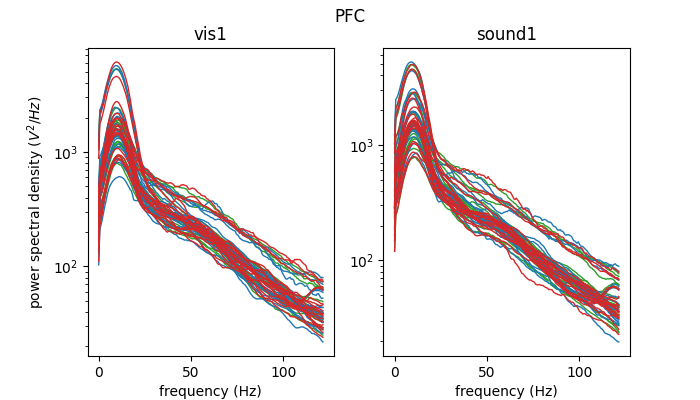

<IPython.core.display.Javascript object>


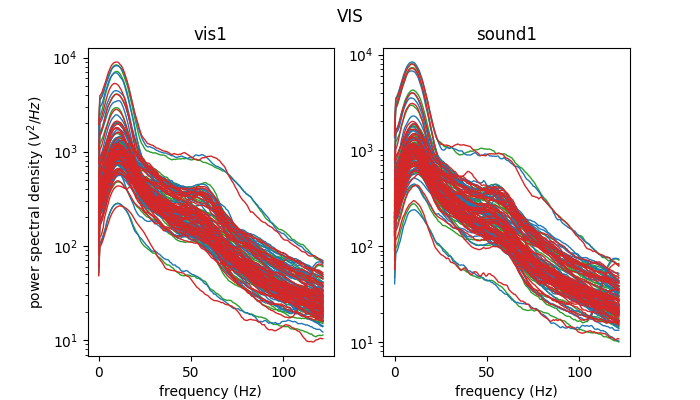

<IPython.core.display.Javascript object>


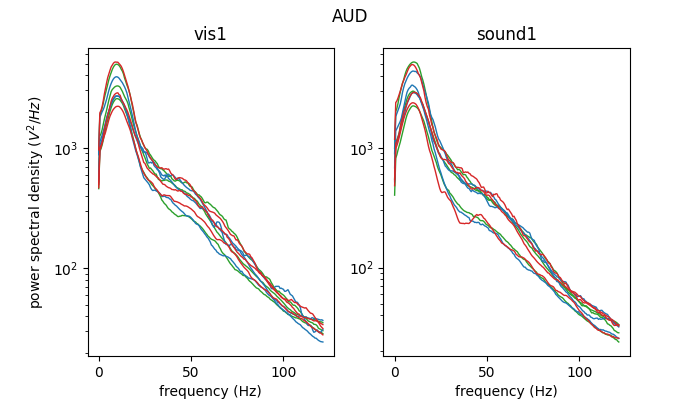

<IPython.core.display.Javascript object>


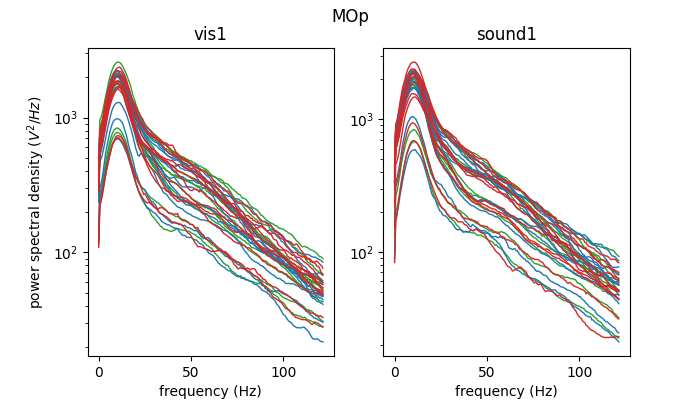

In [126]:
plot_colors={
    'hit':'tab:green',
    'cr':'tab:blue',
    'fa':'tab:red'
}

for sel_area in sel_areas:

    fig,ax=plt.subplots(1,2,figsize=(7,4))
    fig.suptitle(sel_area)
    
    for bb,block in enumerate(block_types):
        ax[bb].set_title(block)
        
        for trial_type in trial_types:
            ax[bb].plot(sample_freqs,avg_power[sel_area][block][trial_type].T,
                        color=plot_colors[trial_type],linewidth=1)
            
            
        ax[bb].set_xlabel('frequency (Hz)')
        ax[bb].set_yscale('log')
        if bb==0:
            ax[bb].set_ylabel('power spectral density ($V^{2}/Hz$)')

In [127]:
np.save(os.path.join(main_save_path,'avg_LFPs_by_area.npy'),avg_LFPs,allow_pickle=True)
np.save(os.path.join(main_save_path,'avg_power_by_area.npy'),avg_power,allow_pickle=True)

In [116]:
# area_channels
# sel_trials.index.values
# channel_areas[channel_areas.isnull()]=''
# X=probe_lfp[:,:,sel_trials.index.values]
# X[:,area_channels].shape

In [117]:
# area_channels.shape

In [118]:
# area_channels

In [ ]:
# session.channels[probe]['region'].str.contains('CP').values

In [ ]:
# 'channel_areas' in session.channels[probe].columns